In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import fcluster

#pd.options.display.max_rows = 999
%matplotlib inline
pd.options.display.max_columns = 99
%config Completer.use_jedi = False

In [2]:
df_gs = pd.read_excel('Rings-trophs-schizonts-metabolomics-GS.ods')
print(df_gs.columns)
df_gs

Index(['Mass', 'RT', 'FORMULA', 'Isomers', 'Putative metabolite', 'confidence',
       'Map', 'Pathway', 'max intensity', 'Fold change rings',
       'Fold change schizonts', 'Fold change trophs', 'urbcs', 'ttest: rings',
       'ttest: schizonts', 'ttest: trophs', 'ttest: urbcs', 'Mean: rings',
       'Mean: schizonts', 'Mean: trophs', 'Mean: urbcs', 'SD: rings',
       'SD: schizonts', 'SD: trophs', 'SD: urbcs', 'RSD: rings',
       'RSD: schizonts', 'RSD: trophs', 'RSD: urbcs', 'Fisher: rings',
       'Fisher: schizonts', 'Fisher: trophs', 'Fisher: urbcs', 'PeakID'],
      dtype='object')


Mass         RT       FORMULA  Isomers  \
0    246.085007  13.846167     C9H14N2O6        2   
1    246.050342  12.506494      C6H15O8P        3   
2    308.158786  20.801533    C12H24N2O7        1   
3    151.049387  11.982563       C5H5N5O        3   
4    193.040960  14.563833     C6H11NO4S        1   
..          ...        ...           ...      ...   
636  355.068833  18.460308  C11H21N3O4S3        1   
637  346.160007  17.385067    C12H22N6O6        1   
638  263.111618  14.489912     C9H17N3O6        2   
639  122.036793   7.385838        C7H6O2        6   
640  166.026617  14.631863        C8H6O4        7   

                   Putative metabolite  confidence  \
0    L-alpha-Aspartyl-L-hydroxyproline         3.0   
1           2-deoxyglucose-6-phosphate         7.0   
2                        psicoselysine         7.0   
3                     2-Hydroxyadenine         5.0   
4         &gamma;-thiomethyl glutamate         7.0   
..                                 ...         ...   
636                        Met-Cys-Cys         7.0   
637                        Asp-Gly-Arg         7.0   
638                        Ala-Ser-Ser         7.0   
639              4-Hydroxybenzaldehyde         5.5   
640                          Phthalate         5.5   

                                           Map  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   
..                                         ...   
636                              Peptide(tri-)   
637                              Peptide(tri-)   
638                              Peptide(tri-)   
639  Xenobiotics Biodegradation and Metabolism   
640  Xenobiotics Biodegradation and Metabolism   

                                               Pathway  max intensity  \
0                                                    0         381655   
1                                                    0         370884   
2         fructoselysine and psicoselysine degradation         828430   
3                                                    0        1198727   
4                                                    0         155371   
..                                                 ...            ...   
636                                Hydrophobic peptide        4565959   
637                                      Basic peptide         441855   
638                                      Polar peptide         405400   
639  Benzoate degradation via hydroxylation__Bisphe...        9487125   
640  2,4-Dichlorobenzoate degradation__Naphthalene ...        3320192   

     Fold change rings  Fold change schizonts  Fold change trophs  urbcs  \
0            16.803283             197.892487          134.977565      0   
1           102.165281             235.331934           70.047003      0   
2             5.222720             127.027723           37.483372      1   
3             8.188554             117.743238           36.291926      1   
4             3.883660              14.774852           16.325356      1   
..                 ...                    ...                 ...    ...   
636           0.774936               0.878283            0.746677      1   
637           0.705106               0.762055            0.692946      1   
638           0.719657               0.360082            0.492323      1   
639           1.862956               1.394512            1.327098      1   
640           1.031224               1.403965            1.133421      1   

     ttest: rings  ttest: schizonts  ttest: trophs  ttest: urbcs  \
0        0.107584          0.021001       0.055473           NaN   
1        0.007717          0.002851       0.091215           NaN   
2        0.016210          0.013809       0.042277           1.0   
3        0.023155          0.001561       0.088617           N

In [162]:
def plt_cluster_maps(df:pd.DataFrame, cols:list, 
                     methods:list=['single', 'complete','average','weighted','centroid','median','ward'],
                     scaling:list=['min_max','log2'],
                     dst:float=None):
    # Make Clustermap plot of fold_changes, scaling can be used to cluster the different attributes
    # sns uses scipy linkage so there are several ordering options ward works the best   
    X = df[cols].values
    # min max scaling
    if 'min_max' in scaling:
        for i in range(len(X)):
            proxy = X[i]
            if proxy.sum()!=0:
                proxy = (proxy-proxy.min())/(proxy.max()-proxy.min())
            X[i] = proxy
    if 'log2' in scaling:
        # limitation zero valus are not considered
        X = np.log2(X, where= X!=0)
        
    dic_linkage = {}
    
    for meth in methods:   
        result = sns.clustermap(X.T, method=meth,
                       row_cluster=False,
                       cmap="viridis",
                       figsize=(15,7),
                       dendrogram_ratio=(.01,.8),
                       )

        dic_linkage[meth] = result.dendrogram_col.linkage
        plt.title(meth.capitalize(),position=(10.,0))
        plt.show()
        
        clusterlabels = []
        if distance != None:
            cluster_labels = cluster_wth_red_line(X,meth, dstnc=distance,
                                                  linkage=dic_linkage[meth])
            cluster_graphs(X, cluster_labels)
    return dic_linkage, cluster_labels

def cluster_wth_red_line(series_list, meth, linkage, dstnc:float)-> list:
    cluster_labels = fcluster(linkage, dstnc, criterion='distance')
    # Make color map for clustermap 
    cmap = cm.flag
    norm = Normalize(vmin=0, vmax=len(set(cluster_labels)))
    values = [cmap(norm(x)) for x  in set(cluster_labels)]
    lut = dict(zip(set(cluster_labels), values))
    row_colors= [lut[x] for x in cluster_labels]
    
    # make clustermap but this time with coloring for each cluster
    result = sns.clustermap(series_list.T, method=meth,
                            row_cluster=False,
                            cmap="viridis",
                            col_colors=row_colors,
                            figsize=(15,7),
                            dendrogram_ratio=(.01,.8))
    # produce red line in dendrogram to show where cut-off for clusters
    ax = result.ax_col_dendrogram
    ax.plot([0, 10000], [1,1], 'r-', lw = 1)
    plt.show()
    return cluster_labels

def cluster_graphs(series_list, labels:list):

    cluster_count = len(set(labels))
    
    plot_count = math.ceil(math.sqrt(cluster_count))

    fig, axs = plt.subplots(plot_count,plot_count,figsize=(15,7))
    row_i=0
    column_j=0
    for label in set(labels):
        cluster = []
        for i in range(len(labels)):
                if(labels[i]==label):
                    axs[row_i, column_j].plot(series_list[i],c="gray",alpha=0.4)
                    cluster.append(series_list[i])
        if len(cluster) > 0:
            axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")

        axs[row_i, column_j].set_title("Trend-Cluster "+str(row_i*(plot_count)+column_j+1))

        column_j+=1
        if column_j%plot_count == 0:
            row_i+=1
            column_j=0

    plt.tight_layout()       
    plt.show()
    return

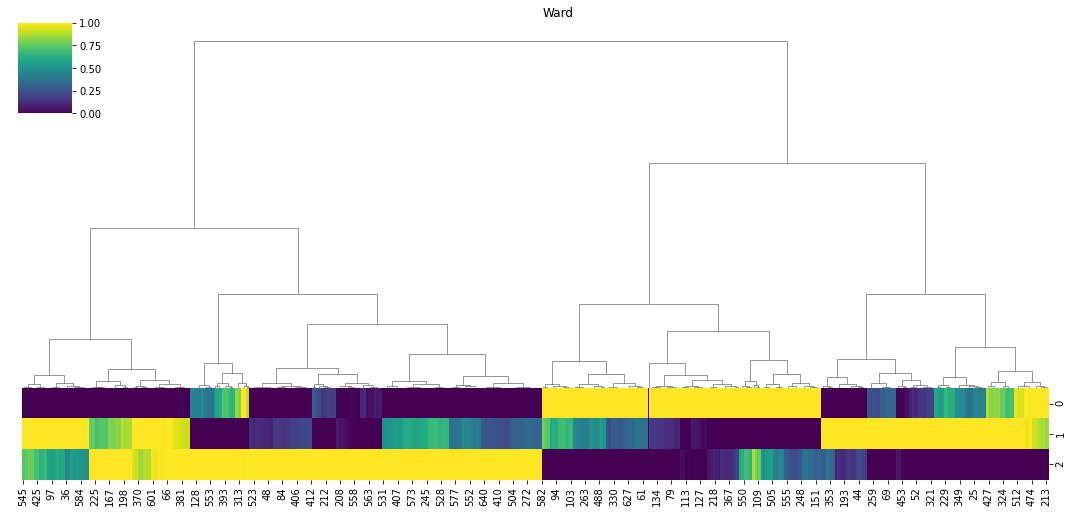

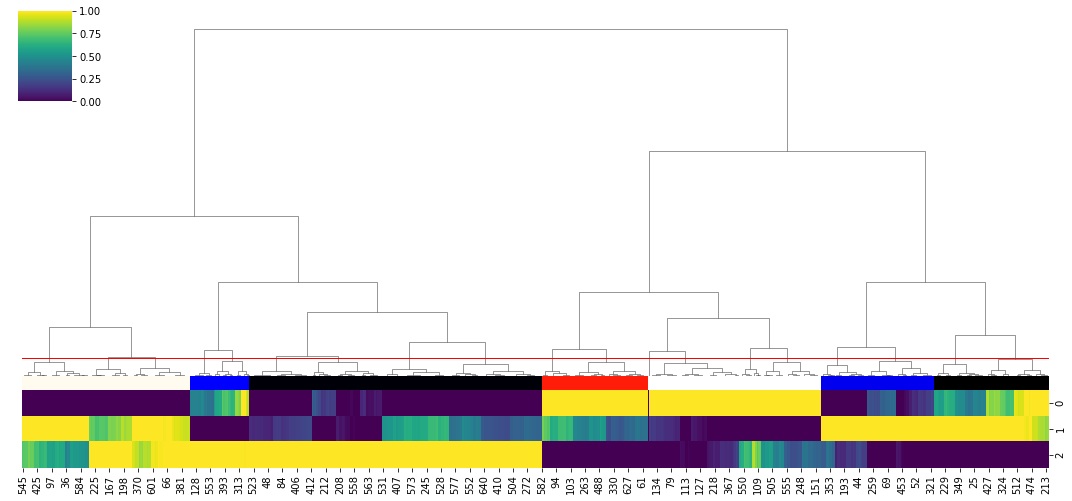

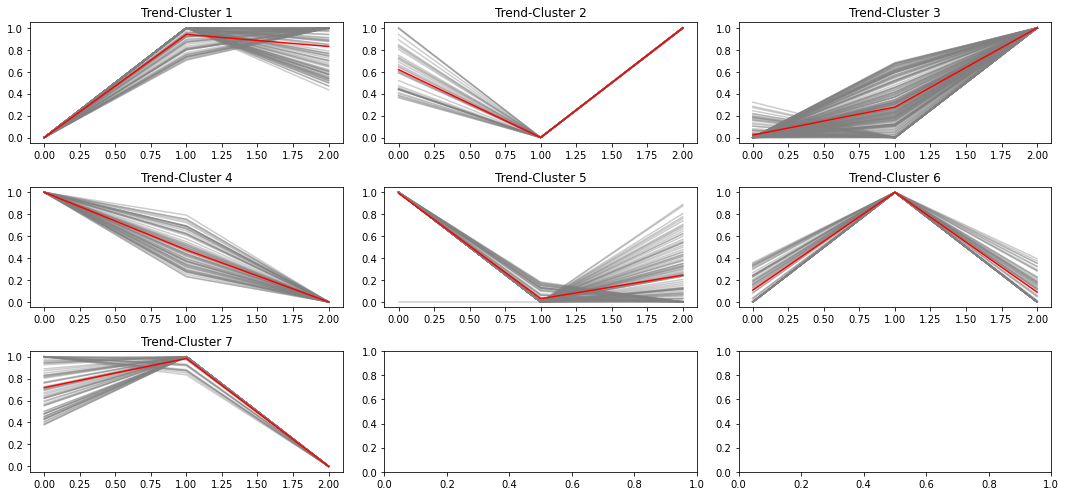

({'ward': array([[1.59000000e+02, 3.09000000e+02, 0.00000000e+00, 2.00000000e+00],
         [6.20000000e+02, 6.41000000e+02, 0.00000000e+00, 3.00000000e+00],
         [1.11000000e+02, 2.65000000e+02, 8.48967411e-06, 2.00000000e+00],
         ...,
         [1.27200000e+03, 1.27600000e+03, 8.81389962e+00, 3.25000000e+02],
         [1.27500000e+03, 1.27700000e+03, 1.23717348e+01, 3.16000000e+02],
         [1.27800000e+03, 1.27900000e+03, 1.91063222e+01, 6.41000000e+02]])},
 array([3, 3, 3, 3, 1, 3, 1, 7, 1, 1, 1, 5, 1, 7, 3, 2, 6, 4, 1, 7, 7, 3,
        3, 7, 1, 7, 3, 3, 3, 4, 3, 3, 7, 3, 7, 1, 1, 6, 1, 3, 7, 7, 6, 3,
        6, 6, 2, 5, 3, 3, 6, 7, 6, 6, 3, 1, 5, 3, 3, 4, 6, 4, 3, 3, 1, 6,
        1, 1, 6, 6, 6, 3, 7, 6, 6, 4, 6, 3, 5, 5, 6, 6, 6, 1, 3, 3, 4, 7,
        5, 1, 4, 4, 1, 6, 4, 5, 6, 1, 5, 4, 4, 3, 5, 4, 5, 5, 6, 2, 5, 5,
        5, 4, 2, 5, 5, 3, 5, 5, 5, 5, 5, 4, 2, 4, 4, 5, 4, 5, 2, 5, 2, 5,
        2, 4, 5, 5, 5, 2, 5, 5, 5, 7, 5, 5, 3, 3, 5, 5, 5, 2, 5, 5, 5, 5,
       

In [163]:
plt_cluster_maps(df_gs, methods=['ward'], scaling=['min_max'], dst=2.0,
                 cols=['Fold change rings', 'Fold change trophs','Fold change schizonts'])

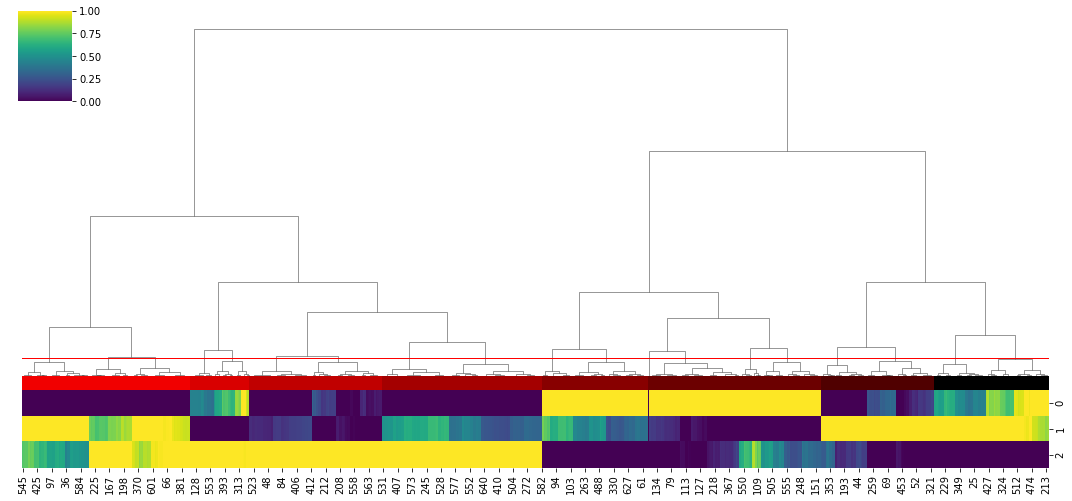

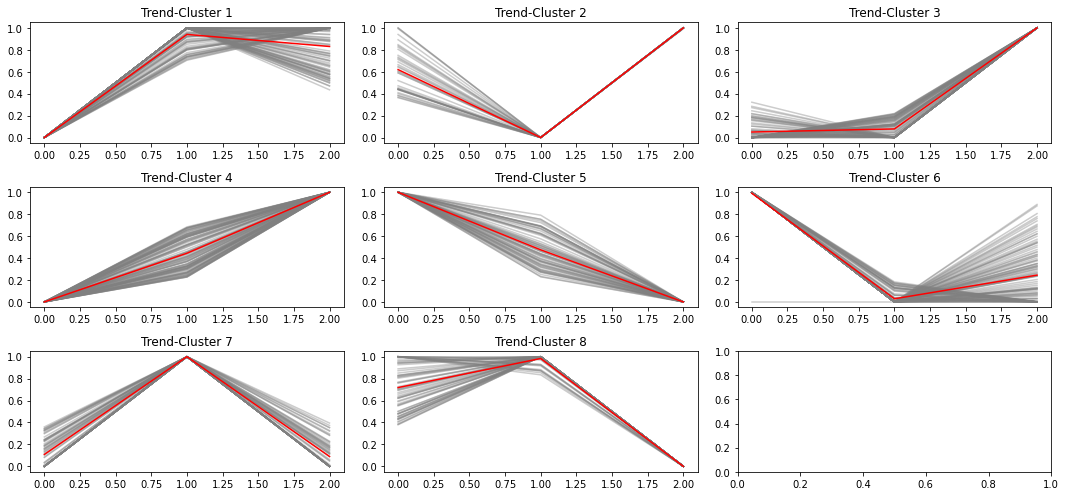

In [133]:
# Make maximum Cluster number and than color them, but needs dendrogram_row.linkage
# select maximum number of clusters
#cluster_labels = fcluster(result.dendrogram_row.linkage, 2.5, criterion='distance')
linkage_dis = {'ward':2.5,        # 1 for 12 groups
               'single':0.099,    # not good measure
               'complete':1.2,    # 0.5 for 12 groups
               'average':0.7,     # 0.3 for 12 groups
               'weighted':0.7,    # 0.29 for 12 groups
               'centroid':0.65,   # 0.299 for 12 groups
               'median':0.7       # 0.28 for 12 groups
              }
meth = 'ward'
cluster_labels = fcluster(dic_linkage[meth], 3.5, criterion='distance')
# Make color map for clustermap 
cmap = cm.flag
norm = Normalize(vmin=0, vmax=len(set(cluster_labels)))
values = [cmap(norm(x)) for x  in set(cluster_labels)]
lut = dict(zip(set(cluster_labels), values))
row_colors= [lut[x] for x in cluster_labels]
# make clustermap but this time with coloring for each cluster
result = sns.clustermap(X.T, method=meth,
                        row_cluster=False,
                        cmap="viridis",
                        col_colors=row_colors,
                        figsize=(15,7),
                        dendrogram_ratio=(.01,.8),
                   )
# produce red line in dendrogram to show where cut-off for clusters
ax = result.ax_col_dendrogram
ax.plot([0, 10000], [1,1], 'r-', lw = 1)
plt.show()

labels = cluster_labels
cluster_count = len(set(labels))
series_list= X

plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(15,7))
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(series_list[i],c="gray",alpha=0.4)
                cluster.append(series_list[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    
    axs[row_i, column_j].set_title("Trend-Cluster "+str(row_i*(plot_count)+column_j+1))

    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.tight_layout()       
plt.show()

<AxesSubplot:xlabel='trend_clusters'>

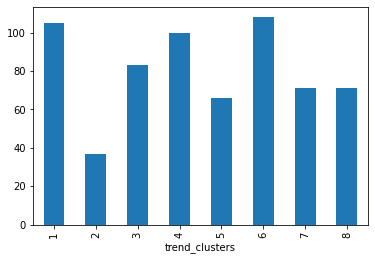

In [87]:
df_gs['trend_clusters'] = cluster_labels
df_gs.groupby(by='trend_clusters').count()['Mass'].plot.bar() 

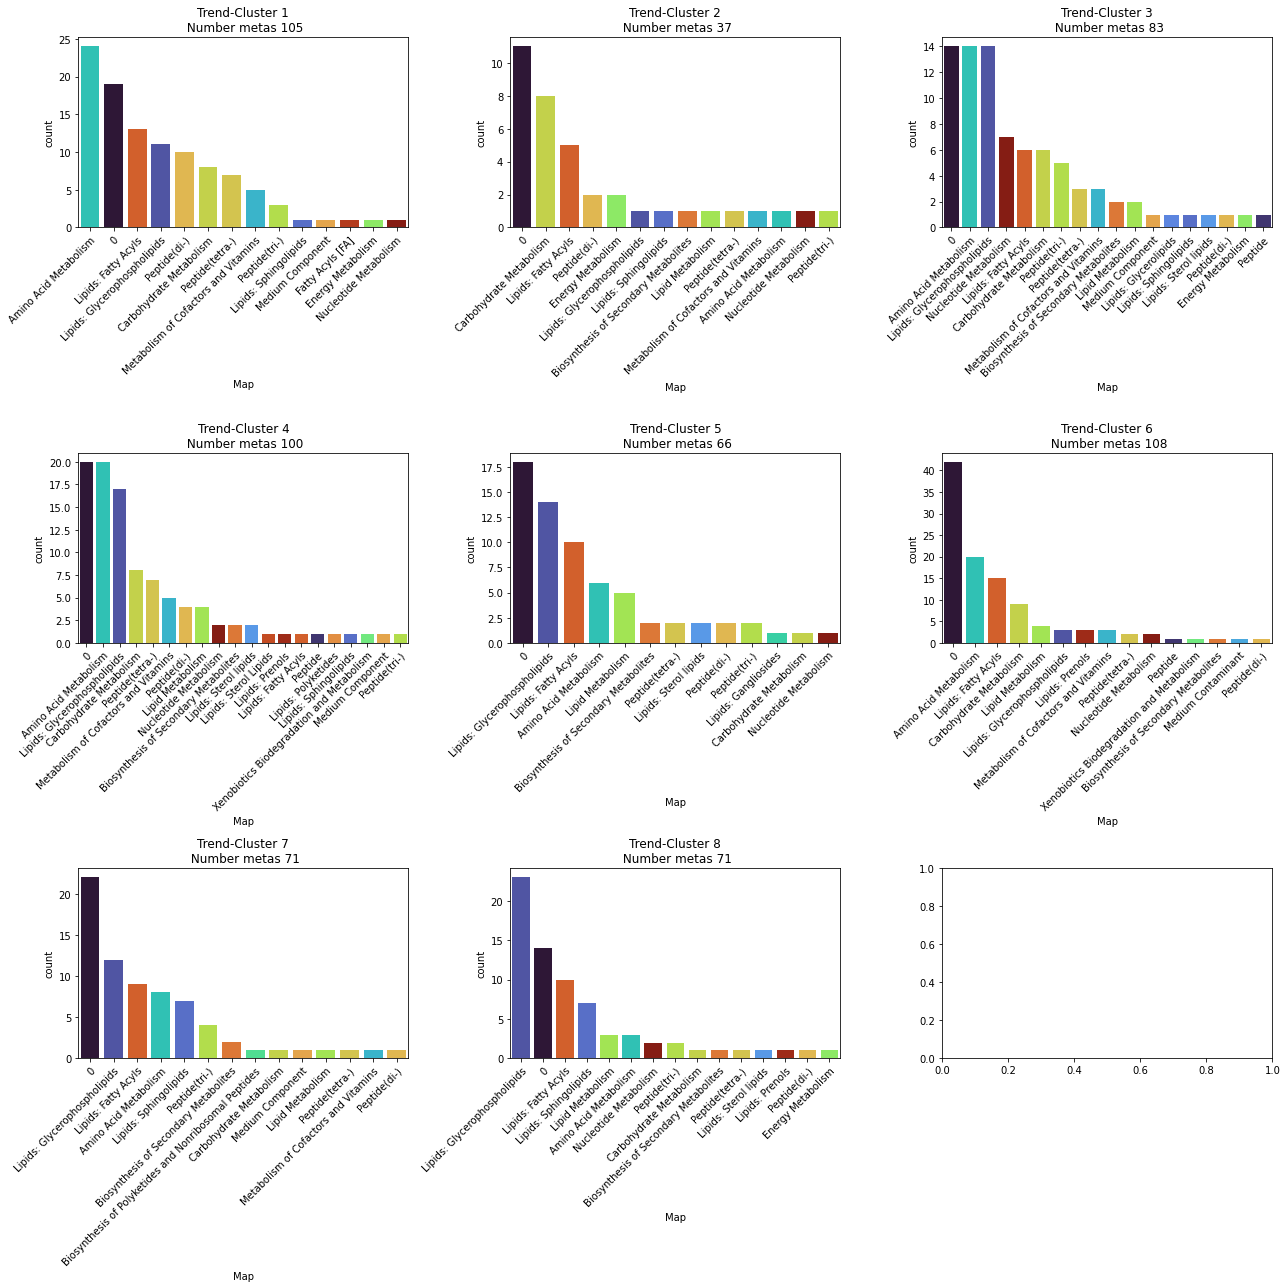

In [26]:
df_gs['trend_clusters'] = cluster_labels
maps = df_gs['Map'].unique() 
cmap = cm.turbo
norm = Normalize(vmin=0, vmax=len(maps))

values = [cmap(norm(x)) for x in range(len(maps))]
lut = dict(zip(set(maps), values))

labels = cluster_labels
cluster_count = len(set(labels))

som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(series_list))))
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(18,18))
#fig.suptitle('Clusters')
row_i=0
column_j=0

for i in set(cluster_labels):
    
    names = df_gs[df_gs['trend_clusters']==i]['Map'].value_counts().index
    
    sns.countplot(ax=axs[row_i, column_j], x='Map',
                  palette=lut,
                  data=df_gs[df_gs['trend_clusters']==i],
                  order=df_gs[df_gs['trend_clusters']==i]['Map'].value_counts().index)
    
    axs[row_i, column_j].set_title("Trend-Cluster "+str(i)
                                   +'\n Number metas '
                                   +str(df_gs[df_gs['trend_clusters']==i]['Map'].value_counts().sum()))
    axs[row_i, column_j].set_xticks(np.arange(0,len(names),1))
    axs[row_i, column_j].set_xticklabels(names,rotation=45, rotation_mode="anchor", ha="right")
    
    column_j+=1
    
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.tight_layout()
plt.show()
    #print(df_gs[df_gs['cluster']==i]['Map'].value_counts())

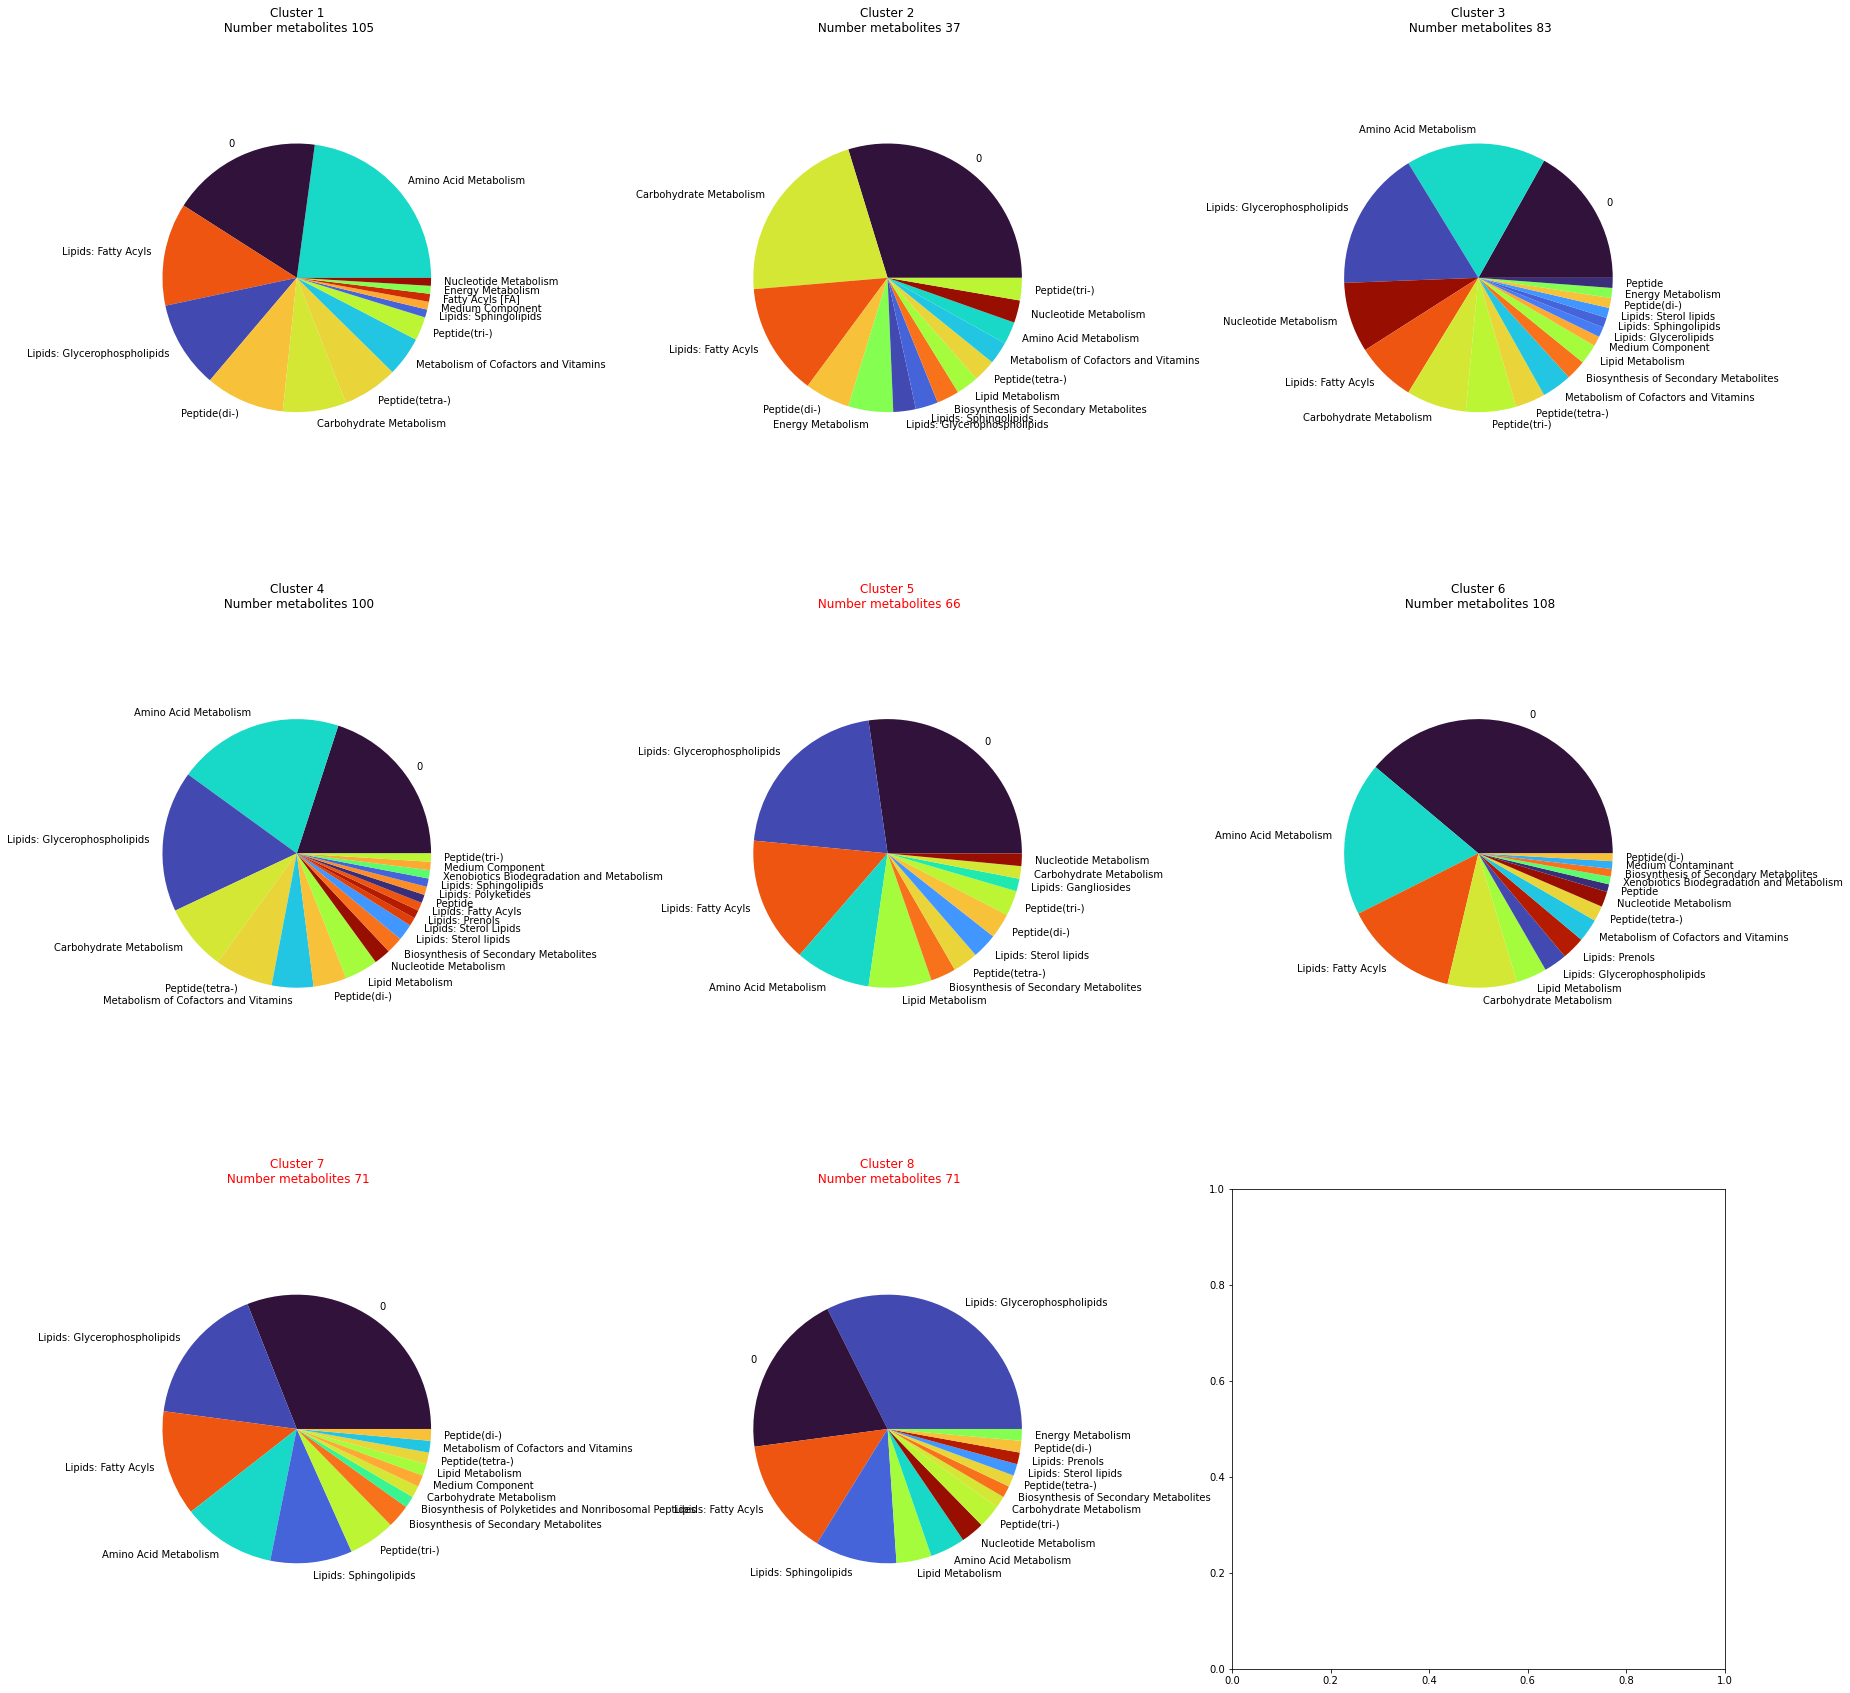

In [31]:
fig, axs = plt.subplots(plot_count,plot_count,figsize=(30,30))
#fig.suptitle('Clusters')
row_i=0
column_j=0

for i in set(cluster_labels):
    
    names = df_gs[df_gs['trend_clusters']==i]['Map'].value_counts().index
    
    axs[row_i, column_j].pie(x=df_gs[df_gs['trend_clusters']==i]['Map'].value_counts(),
                             labels=names,
                             colors=[lut[x] for x in names],
                             data=df_gs[df_gs['trend_clusters']==i]['Map'].value_counts(),
                             radius=0.7)
    col='black'
    for x in names[0:2:]:
        if 'lipid' in str(x) or 'Lipid' in str(x):
            col='r'
    axs[row_i, column_j].set_title("Cluster "+str(i)
                                   +'\n Number metabolites '+str(df_gs[df_gs['trend_clusters']==i]['Map'].value_counts().sum()),
                                   color=col)
    #axs[row_i, column_j].set_xticks(np.arange(0,len(names),1))
    #axs[row_i, column_j].set_xticklabels(names,rotation=45, rotation_mode="anchor", ha="right")
    
    column_j+=1
    
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
#plt.tight_layout()
plt.show()

In [32]:
df_gs[df_gs['Putative metabolite'].str.contains(
                                       "PS")].sort_values(by='Putative metabolite')[['Putative metabolite',
                                                                                     'trend_clusters',
                                                                                     'Fold change rings', 
                                                                                     'Fold change trophs',
                                                                                     'Fold change schizonts',
                                                                                     'RSD: rings',
                                                                                     'RSD: trophs',
                                                                                     'RSD: schizonts',
                                                                                     'RSD: urbcs']]                                                                                       

Putative metabolite  trend_clusters  \
535                                               CAPS               1   
112                                              CHAPS               2   
465                                           PS(18:0)               2   
409                               PS(18:2(9Z,12Z)/0:0)               7   
458                PS(22:6(4Z,7Z,10Z,13Z,16Z,19Z)/0:0)               5   
410                                           PS(34:0)               4   
425                                           PS(34:1)               1   
412                                           PS(36:0)               3   
430                                           PS(36:1)               7   
428                                           PS(36:2)               1   
419                                           PS(36:3)               4   
438                                           PS(36:4)               1   
453                                           PS(38:5)               7   
441                                           PS(38:6)               7   
472                                           PS(40:4)               8   
466                                           PS(40:5)               8   
488                                           PS(40:8)               5   
480                                          PS(42:10)               8   
457  [PS(18:0/20:4)] 1-octadecanoyl-2-(5Z,8Z,11Z,14...               7   
418  [PS(18:1)] 1-(9Z-octadecenoyl)-sn-glycero-3-ph...               1   
449  [PS(20:4)] 1-(5Z,8Z,11Z,14Z-eicosatetraenoyl)-...               8   

     Fold change rings  Fold change trophs  Fold change schizonts  RSD: rings  \
535           0.811849            1.148115               0.997428    0.927012   
112           0.576653            0.532571               0.632159    0.936082   
465           1.162422            1.068867               1.248909    0.266772   
409           5.459565           16.991050               9.228424    0.241593   
458           1.326171            1.164976               0.839732    0.277586   
410           7.720681           16.289126              42.153051    0.228896   
425           1.238773            2.268354               1.961031    0.379400   
412           4.142824            8.795566              25.382279    0.187361   
430           1.409514            2.005858               1.538034    0.228785   
428           1.365088            2.154012               2.434475    0.163551   
419           1.702714            3.020608               3.935910    0.262592   
438           0.934945            1.489165               1.210441    0.186161   
453           0.934162            1.227517               0.939051    0.198079   
441           1.037757            1.456748               1.202999    0.275509   
472           1.048275            1.001567               0.674895    0.323758   
466           0.986608            1.058536               0.824387    0.192551   
488           0.859626            0.812239               0.765218    0.315421   
480           0.873702            0.884266               0.821815    0.129617   
457           0.994030            1.176299               0.897864    0.184539   
418           1.798666            3.333125               2.720753    0.206841   
449           1.264415            1.312374               0.664897    0.182975   

     RSD: trophs  RSD: schizonts  RSD: urbcs  
535     0.825479        0.775930    0.640350  
112     0.832429        0.749474    0.271251  
465     0.295019        0.522964    0.250187  
409     0.426468        0.111258         NaN  
458     0.320693        0.352550    0.283552  
410     0.315770        0.290421    0.876465  
425     0.307880        0.086315    0.365503  
412     0.364368        0.269273    0.254071  
430     0.130633        0.073505    0.309494  
428     0.225295        0.113831    0.104730  
419     0.394686        0.090429    0.195504  
438     0.265639        0.274517    0.195801  
453     0.14

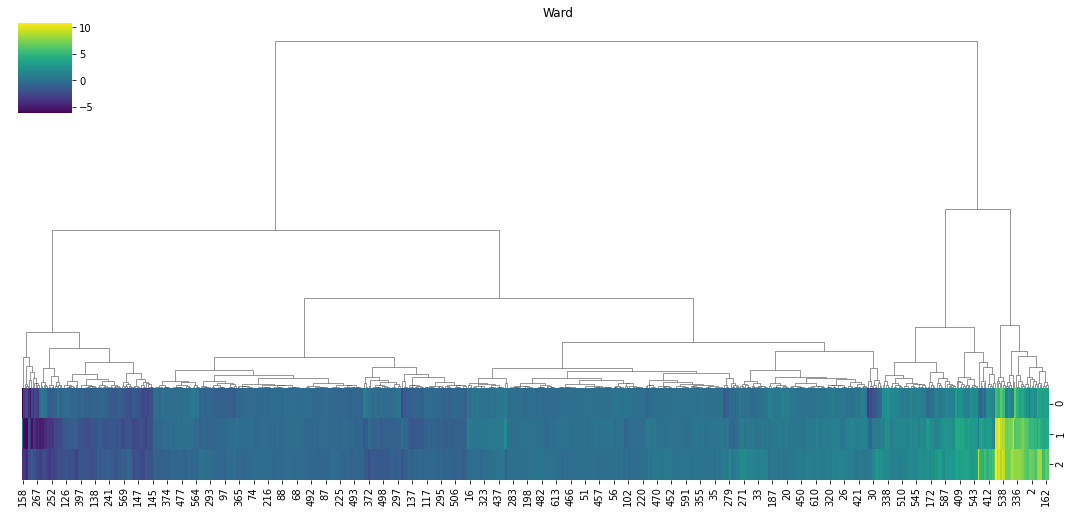

In [95]:
# Make Clustermap plot of only the foldchanges, here no scaling 
#sns uses scipy linkage so there are several ordering options ward works the best

X = df_gs[['Fold change rings', 'Fold change trophs','Fold change schizonts']].values
X_log2 = np.log2(X, where= X!=0)
orders = pd.DataFrame(columns=['single', 'complete','average','weighted','centroid','median','ward'])
dic_linkage = {}

for meth in ['ward']:   
    result = sns.clustermap(X_log2.T, method=meth,
                   row_cluster=False,
                   cmap="viridis",
                   figsize=(15,7),
                   dendrogram_ratio=(.01,.8),
                   )
    orders[meth] = result.dendrogram_col.reordered_ind
    #pd_fcluster[meth] = fcluster(result.dendrogram_row.linkage, 2., criterion='distance')
    dic_linkage[meth] = result.dendrogram_col.linkage
    plt.title(meth.capitalize(),position=(10.,0))
    plt.show()

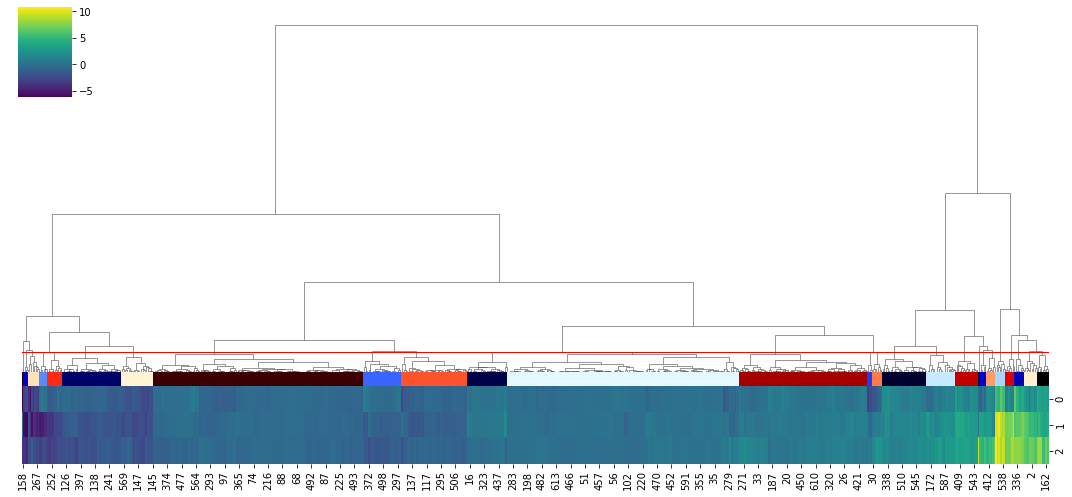

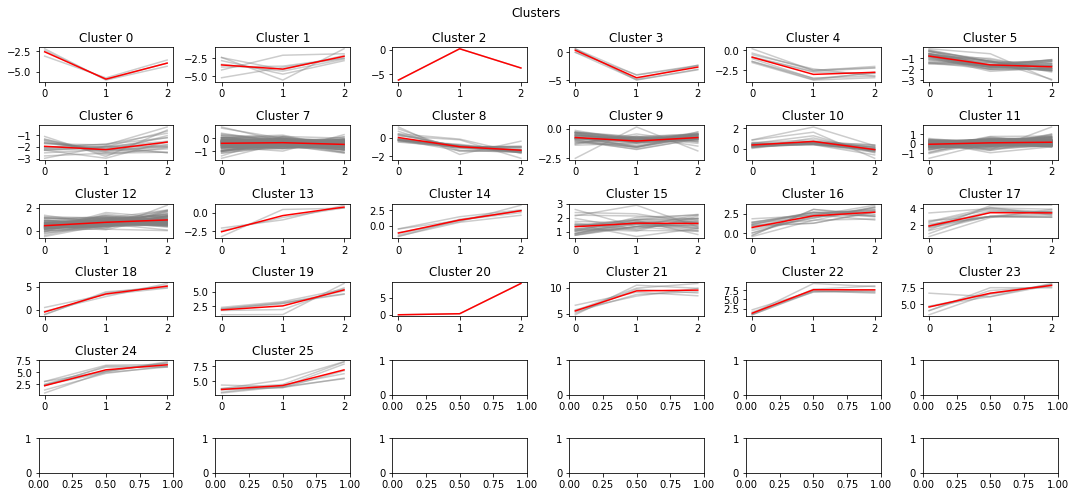

<AxesSubplot:xlabel='log2_clusters'>

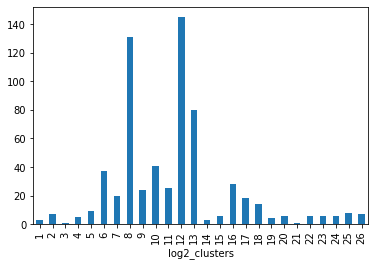

In [96]:
distance=5
cluster_labels = fcluster(dic_linkage[meth], distance, criterion='distance')

# Make color map for clustermap 
cmap = cm.flag
norm = Normalize(vmin=0, vmax=len(set(cluster_labels)))
values = [cmap(norm(x)) for x  in set(cluster_labels)]
lut = dict(zip(set(cluster_labels), values))
row_colors= [lut[x] for x in cluster_labels]
# make clustermap but this time with coloring for each cluster
result = sns.clustermap(X_log2.T, method=meth,
                        row_cluster=False,
                        cmap="viridis",
                        col_colors=row_colors,
                        figsize=(15,7),
                        dendrogram_ratio=(.01,.8),
                   )
# produce red line in dendrogram to show where cut-off for clusters
ax = result.ax_col_dendrogram
ax.plot([0, 10000], [distance,distance], 'r-', lw = 1)
plt.show()


# plot avg. trajectory of cluster in red and in grey each species belonging to cluster
labels = cluster_labels
cluster_count = len(set(labels))
series_list = X_log2

plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(15,7))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(series_list[i],c="gray",alpha=0.4)
                cluster.append(series_list[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*(plot_count)+column_j))
    
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.tight_layout()       
plt.show()
df_gs['log2_clusters']= cluster_labels
df_gs.groupby(by='log2_clusters').count()['Mass'].plot.bar() 

<ipython-input-98-05eb6e5b4bcf>:38: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


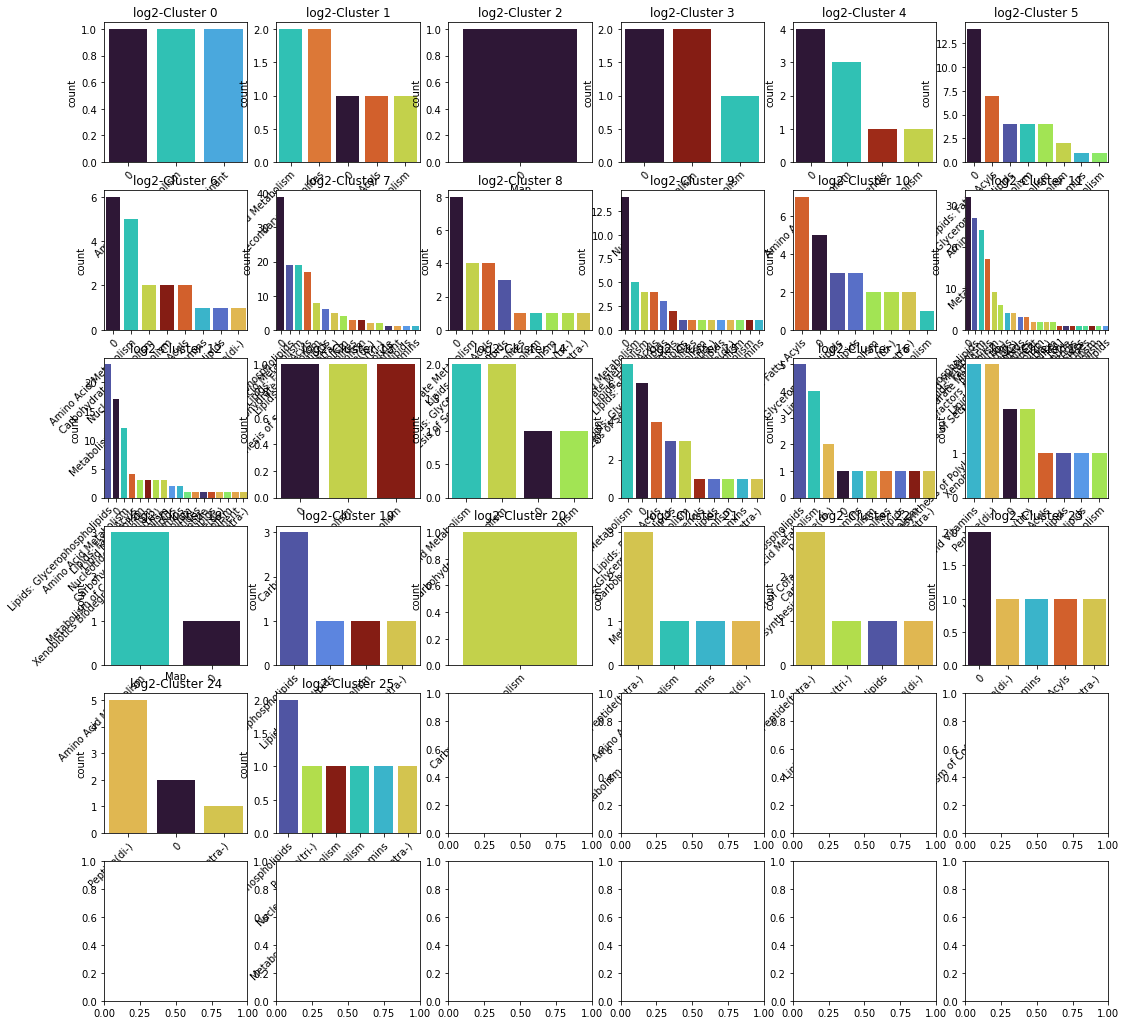

In [98]:
# plot each clusters maps as bar plot, as enrichment analysis 
df_gs['log2_clusters'] = cluster_labels
maps = df_gs['Map'].unique() 
cmap = cm.turbo
norm = Normalize(vmin=0, vmax=len(maps))

values = [cmap(norm(x)) for x in range(len(maps))]
lut = dict(zip(set(maps), values))

labels = cluster_labels
cluster_count = len(set(labels))

plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(18,18))
#fig.suptitle('Clusters')
row_i=0
column_j=0

for i in set(cluster_labels):
    
    names = df_gs[df_gs['log2_clusters']==i]['Map'].value_counts().index
    
    sns.countplot(ax=axs[row_i, column_j], x='Map',
                  palette=lut,
                  data=df_gs[df_gs['log2_clusters']==i],
                  order=df_gs[df_gs['log2_clusters']==i]['Map'].value_counts().index)

    axs[row_i, column_j].set_title("log2-Cluster "+str(row_i*(plot_count)+column_j))
    axs[row_i, column_j].set_xticks(np.arange(0,len(names),1))
    axs[row_i, column_j].set_xticklabels(names,rotation=45, rotation_mode="anchor", ha="right")
    
    column_j+=1
    
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
plt.tight_layout()
plt.show()

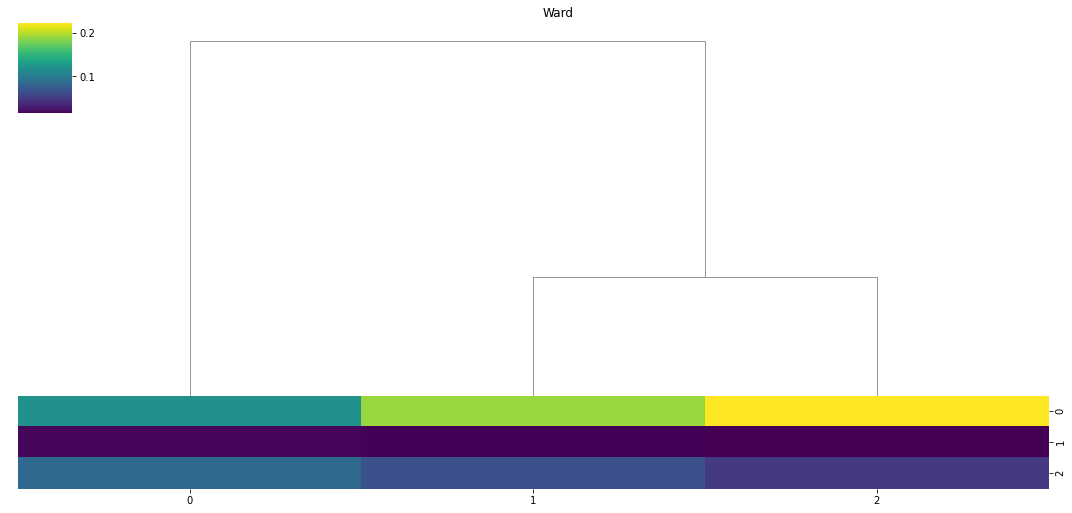

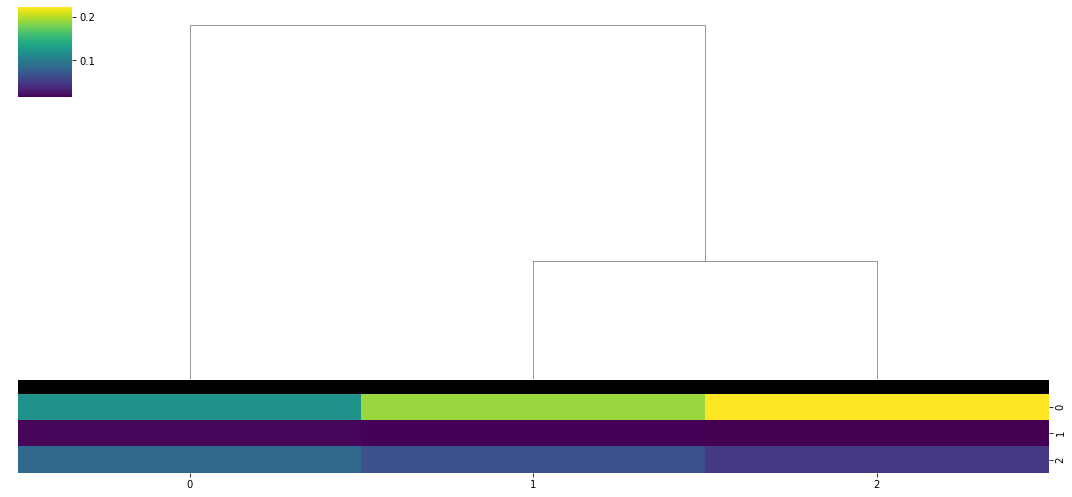

TypeError: 'AxesSubplot' object is not subscriptable

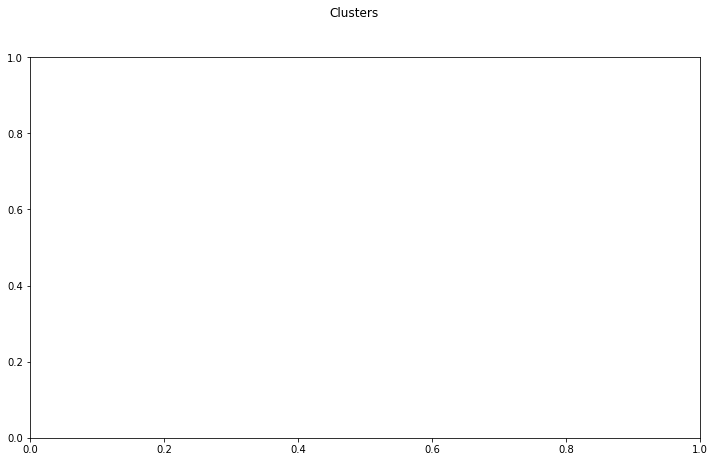

In [100]:
small_cluster = df_gs[df_gs['log2_clusters']==1].copy()
X = small_cluster[['Fold change rings', 'Fold change trophs','Fold change schizonts']].values

orders = pd.DataFrame(columns=['single', 'complete','average','weighted','centroid','median','ward'])
dic_linkage = {}

for meth in ['ward']:   
    result = sns.clustermap(X.T, method=meth,
                   row_cluster=False,
                   cmap="viridis",
                   figsize=(15,7),
                   dendrogram_ratio=(.01,.8),
                   )
    orders[meth] = result.dendrogram_col.reordered_ind
    #pd_fcluster[meth] = fcluster(result.dendrogram_row.linkage, 2., criterion='distance')
    dic_linkage[meth] = result.dendrogram_col.linkage
    plt.title(meth.capitalize(),position=(10.,0))
    plt.show()

distance = 4
cluster_labels = fcluster(dic_linkage[meth], distance, criterion='distance')

# Make color map for clustermap 
cmap = cm.flag
norm = Normalize(vmin=0, vmax=len(set(cluster_labels)))
values = [cmap(norm(x)) for x  in set(cluster_labels)]
lut = dict(zip(set(cluster_labels), values))
row_colors= [lut[x] for x in cluster_labels]
# make clustermap but this time with coloring for each cluster
result = sns.clustermap(X.T, method=meth,
                        row_cluster=False,
                        cmap="viridis",
                        col_colors=row_colors,
                        figsize=(15,7),
                        dendrogram_ratio=(.01,.8),
                   )
# produce red line in dendrogram to show where cut-off for clusters
ax = result.ax_col_dendrogram
ax.plot([0, 10000], [distance,distance], 'r-', lw = 1)
plt.show()


# plot avg. trajectory of cluster in red and in grey each species belonging to cluster
labels = cluster_labels
cluster_count = len(set(labels))
series_list = X

plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(12,7))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(series_list[i],c="gray",alpha=0.4)
                cluster.append(series_list[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*(plot_count)+column_j))
    
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.tight_layout()       
plt.show()

# plot each clusters maps as bar plot, as enrichment analysis 
small_cluster['small_clusters'] = cluster_labels
maps = df_gs['Map'].unique() 
cmap = cm.turbo
norm = Normalize(vmin=0, vmax=len(maps))

values = [cmap(norm(x)) for x in range(len(maps))]
lut = dict(zip(set(maps), values))

labels = cluster_labels
cluster_count = len(set(labels))

plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(30,30))
#fig.suptitle('Clusters')
row_i=0
column_j=0

for i in set(cluster_labels):
    
    names = small_cluster[small_cluster['small_clusters']==i]['Map'].value_counts().index
    
    axs[row_i, column_j].pie(x=small_cluster[small_cluster['small_clusters']==i]['Map'].value_counts(),
                             labels=names,
                             colors=[lut[x] for x in names],
                             data=small_cluster[small_cluster['small_clusters']==i]['Map'].value_counts(),
                             radius=0.7)
    col='black'
    for x in names[0:3:]:
        if 'lipid' in str(x) or 'Lipid' in str(x):
            col='r'
    axs[row_i, column_j].set_title("small-Cluster "+str(row_i*(plot_count)+column_j), color=col)
    #axs[row_i, column_j].set_xticks(np.arange(0,len(names),1))
    #axs[row_i, column_j].set_xticklabels(names,rotation=45, rotation_mode="anchor", ha="right")
    
    column_j+=1
    
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
#plt.tight_layout()
plt.show()

In [101]:
X = small_cluster[['Fold change rings', 'Fold change trophs','Fold change schizonts']].values
X

array([[0.11926611, 0.01883775, 0.08565055],
       [0.19110287, 0.01648123, 0.06610555],
       [0.22283474, 0.01561069, 0.05048911]])

In [12]:
arr = np.append(df_gs['Map'].unique(), (df_gs['Pathway'].unique()))
lst = []
for x in arr:
    try:
        if 'lipid' in x or 'Lipid' in x or 'Fatty' in x or 'fatty' in x :
            lst.append(x)
    except:
        continue
df_gs_lip = df_gs[df_gs['Map'].isin(lst)].copy()
df_gs_lip.drop_duplicates()
df_gs_lip.head()

Mass         RT        FORMULA  Isomers  \
315  340.255418  10.530647     C20H28D4O4        1   
316  183.066094  14.381927      C5H14NO4P        1   
317  172.146312   3.849645       C10H20O2       24   
318  446.060588  16.050892  C11H20N4O11P2        1   
319  215.056038  15.291949      C5H14NO6P        1   

                                   Putative metabolite  confidence  \
315  5S,12R-dihydroxy-6Z,8E,10E,14Z-eicosatetraenoi...         7.0   
316                                  Choline phosphate        10.0   
317                                      Decanoic acid        10.0   
318                                   CDP-ethanolamine         6.0   
319                   sn-glycero-3-Phosphoethanolamine         8.0   

                  Map                                            Pathway  \
315  Fatty Acyls [FA]                              Leukotrienes [FA0302]   
316  Lipid Metabolism  Glycerophospholipid metabolism__Glycine, serin...   
317  Lipid Metabolism                            Fatty acid biosynthesis   
318  Lipid Metabolism                     Glycerophospholipid metabolism   
319  Lipid Metabolism  Glycerophospholipid metabolism__Ether lipid me...   

     max intensity  Fold change rings  Fold change schizonts  \
315         537110           1.025775               1.158900   
316       72207344           1.642291              14.559746   
317        1285475           3.351923               2.478755   
318        1248247           0.687175               5.878628   
319         873732           1.800161               2.695767   

     Fold change trophs  urbcs  ttest: rings  ttest: schizonts  ttest: trophs  \
315            1.175011      1      0.842837          0.280439       0.263743   
316            7.540409      1      0.344769          0.027897       0.015409   
317            3.123806      1      0.097412          0.113804       0.149772   
318            2.695609      1      0.349285          0.003992       0.059130   
319            1.908190      1      0.268976          0.025802       0.086794   

     ttest: urbcs   Mean: rings  Mean: schizonts  Mean: trophs   Mean: urbcs  \
315           1.0  4.161535e+05     4.701617e+05  4.766977e+05  4.056965e+05   
316           1.0  4.525784e+06     4.012339e+07  2.077967e+07  2.755775e+06   
317           1.0  8.144337e+05     6.022757e+05  7.590070e+05  2.429751e+05   
318           1.0  9.268195e+04     7.928734e+05  3.635673e+05  1.348739e+05   
319           1.0  3.407823e+05     5.103265e+05  3.612331e+05  1.893066e+05   

        SD: rings  SD: schizonts    SD: trophs     SD: urbcs  RSD: rings  \
315  4.044565e+04   5.275579e+04  6.574702e+04  7.580226e+04    0.097189   
316  1.314921e+06   2.493374e+07  7.998968e+06  2.465705e+06    0.290540   
317  4.832775e+05   3.979210e+05  5.372748e+05  6.749947e+04    0.593391   
318  1.953299e+04   2.667982e+05  1.608006e+05  6.030629e+04    0.210753   
319  2.230398e+05   2.120279e+05  1.399337e+05  3.930546e+04    0.654494   

     RSD: schizonts  RSD: trophs  RSD: urbcs Fisher: rings Fisher: schizonts  \
315        0.112208     0.137922    0.186845      0.014813          0.487243   
316        0.621426     0.384942    0.894741      0.401209          2.224281   
317        0.660696     0.707865    0.277804      1.371469          0.792505   
318        0.336495     0.442286    0.447131      0.443004          5.786878   
319        0.415475     0.387378    0.207629      0.447341          2.216173   

    Fisher: trophs  Fisher: urbcs PeakID  trend_clusters  absolute_clusters  
315       0.500681            0.0  p2262               3                  1  
316       4.636685            0.0   p391               9                  1  
317       0.908153            0.0  n1972              10                  1  
318       1.773284            0.0   n684               9                  1  
319       1.399138            0.0  n2108               6                  1

In [13]:
df_gs_lip.sort_values(by='Putative metabolite',inplace=True)
df_gs_lip.reset_index()


index        Mass         RT    FORMULA  Isomers  \
0      396  210.125679   4.325940   C12H18O3        6   
1      406  602.526864   3.413494   C39H70O4        1   
2      369  215.115859  12.131814  C10H17NO4        3   
3      385   86.036750  14.667600     C4H6O2        8   
4      333  216.040113  14.544036   C5H13O7P        1   
..     ...         ...        ...        ...      ...   
213    531  462.371217   3.617459   C29H50O4        1   
214    526  368.344347   3.443741     C27H44        1   
215    329  172.013683  14.836271    C3H9O6P        3   
216    320  257.102634  13.780033  C8H20NO6P        1   
217    319  215.056038  15.291949  C5H14NO6P        1   

                                   Putative metabolite  confidence  \
0                                    (-)-Jasmonic acid         8.0   
1    1-(14-methyl-pentadecanoyl)-2-(8-[3]-ladderane...         5.0   
2                2-Amino-9,10-epoxy-8-oxodecanoic acid         5.0   
3                                          2-Butenoate         5.0   
4                  2-C-Methyl-D-erythritol 4-phosphate         8.0   
..                                                 ...         ...   
213  [ST hydroxy(3:2/3:0/3:0)] (5Z,7E)-(1R,2R,3R)-3...         5.0   
214   [ST] (5Z,7E)-9,10-seco-5,7,10(19)-cholestatriene         7.0   
215                            sn-Glycerol 3-phosphate        10.0   
216                        sn-glycero-3-Phosphocholine        10.0   
217                   sn-glycero-3-Phosphoethanolamine         8.0   

                       Map                                            Pathway  \
0      Lipids: Fatty Acyls                    alpha-Linolenic acid metabolism   
1    Lipids: Glycerolipids                                   Diradylglycerols   
2      Lipids: Fatty Acyls                         Fatty Acids and Conjugates   
3      Lipids: Fatty Acyls                         Fatty Acids and Conjugates   
4         Lipid Metabolism                           Biosynthesis of steroids   
..                     ...                                                ...   
213  Lipids: Sterol lipids                                       Secosteroids   
214  Lipids: Sterol lipids                                       Secosteroids   
215       Lipid Metabolism  Glycerolipid metabolism__Glycerophospholipid m...   
216       Lipid Metabolism  Glycerophospholipid metabolism__Ether lipid me...   
217       Lipid Metabolism  Glycerophospholipid metabolism__Ether lipid me...   

     max intensity  Fold change rings  Fold change schizonts  \
0           299101           0.467947               0.542841   
1           940025           4.099988              24.035437   
2           483141           0.823936               0.763380   
3           161957           0.818429               0.374027   
4         18753354           0.499576               0.454952   
..             ...                ...                    ...   
213         182800           0.756158               0.883042   
214         499937           3.748363              10.396125   
215        6622591           1.401391               0.997633   
216       16586353           1.627562               1.921253   
217         873732           1.800161               2.695767   

     Fold change trophs  urbcs  ttest: rings  ttest: schizonts  ttest: trophs  \
0              0.301652      1      0.342246          0.401991       0.245322   
1              7.884354      1      0.004688          0.000490       0.016342   
2              0.888731      1      0.102585          0.057341       0.347337   
3              0.610221      1      0.538078          0.098945       0.240596   
4              0.313476      1      0.102705          0.184825       0.054523   
..                  ...    ...           ...               ...            ...   
213            0.820223      1      0.193127          0.516915       0.222313   
214            8.236980      1      0.024508          0.018917       0.034209   
215     

In [14]:
df_alex = pd.read_excel('RBC and asexual Pf lipidome.xlsx', skiprows=1, index_col=0)
df_alex

RBC1        RBC2        RBC3      Ring 1  \
CE 16:0                  7.580000    8.470000    7.040000    3.940000   
CE 16:1                  2.300000    4.900000    2.110000    0.000000   
CE 18:1                  9.940000   14.400000    8.710000    3.570000   
CE 18:2                 27.430000   53.540000   27.970000   11.400000   
CE 18:3                  3.980000    8.980000    4.140000    1.040000   
...                           ...         ...         ...         ...   
NaN                           NaN         NaN         NaN         NaN   
Sphingolipids (total)  129.580000  119.730000  198.550000  106.580000   
% Cer                    3.171786    2.096384    2.674389    3.302683   
% DHSM                   0.779441    0.977199    1.062705    1.013323   
% SM                    96.048773   96.926418   96.262906   95.683993   

                           Ring 2      Ring 3  Trophozoite 1  Trophozoite 2  \
CE 16:0                  3.250000    6.760000       8.800000       2.060000   
CE 16:1                  0.000000    3.190000       0.000000       0.000000   
CE 18:1                  1.930000    6.690000       0.000000       0.000000   
CE 18:2                  3.100000   20.640000       0.000000       0.000000   
CE 18:3                  0.000000    3.210000       0.000000       0.000000   
...                           ...         ...            ...            ...   
NaN                           NaN         NaN            NaN            NaN   
Sphingolipids (total)  117.480000  102.670000     210.693333     137.240000   
% Cer                    3.464419    4.003117       3.872927       4.284465   
% DHSM                   0.697991    0.535697       0.961904       1.748761   
% SM                    95.837589   95.461186      95.165169      93.966774   

                       Trophozoite 3  Schizont 1  Schizont 2  Schizont 3  
CE 16:0                    12.860000    3.530000    4.530000    6.440000  
CE 16:1                     4.530000    0.000000    0.000000    0.000000  
CE 18:1                    17.090000    0.000000    0.000000    0.000000  
CE 18:2                    52.560000    0.000000    0.000000    0.000000  
CE 18:3                     8.570000    0.000000    0.000000    0.000000  
...                              ...         ...         ...         ...  
NaN                              NaN         NaN         NaN         NaN  
Sphingolipids (total)     162.780000  136.350000  150.800000  139.020000  
% Cer                       3.237498    4.129080    3.972149    3.524673  
% DHSM                      1.806119    2.097543    3.534483    2.589555  
% SM                       94.956383   93.773377   92.493369   93.885772  

[158 rows x 12 columns]

In [15]:
lst = sorted(df_gs_lip["Putative metabolite"])
index_classes = []
for i,x in enumerate(lst):
    if i == len(lst)-1:
        break
    if x[:2] != lst[i+1][:2]:
        index_classes.append(i+1)
        print(i, x)
# print(index_classes)

0 (-)-Jasmonic acid
1 1-(14-methyl-pentadecanoyl)-2-(8-[3]-ladderane-octanyl)-sn-glycerol
5 2-Hydroxy-1,3-dimethoxy-8,9-methylenedioxycoumestan
7 3,7-Dimethyl-2E,6E-decadien-1,10-dioic acid 
10 3-Oxododecanoic acid
11 4,8-Dimethyl-1,3E,7-nonatriene
12 4-8dimethylnonanoylcarnitine
13 5-Hydroxypentanoate
14 5S,12R-dihydroxy-6Z,8E,10E,14Z-eicosatetraenoic acid-d4
15 8-Epiiridodial glucoside
16 9-Oxononanoic acid
17 Acetoacetate
19 CDP-ethanolamine
20 CMP-N-trimethyl-2-aminoethylphosphonate
21 Cer(d40:2)
24 Choline phosphate
26 Dehydrophytosphingosine
27 Dodecanoic acid
55 FA(16:1)
56 Ganglioside GA1 (d18:1/16:0)
57 Hexadecanoic acid
59 Linoleate
72 LysoPE(22:4)
73 Margaroyl-EA
74 N,N-dimethyl-9S,11R,15S-trihydroxy-5Z,13E-prostadien-1-amide
78 N-stearoyl tyrosine
79 Nebrosteroid M
82 O-Propanoylcarnitine
83 Octadecanoic acid
90 PA(36:4)
105 PC(40:6)
126 PE(P-40:4)
132 PG(36:2)
139 PI(38:5)
155 PS(42:10)
164 SM(d42:3)
165 Suberic acid
166 Taurine
167 Tetradecanoic acid
168 Traumatic acid
18

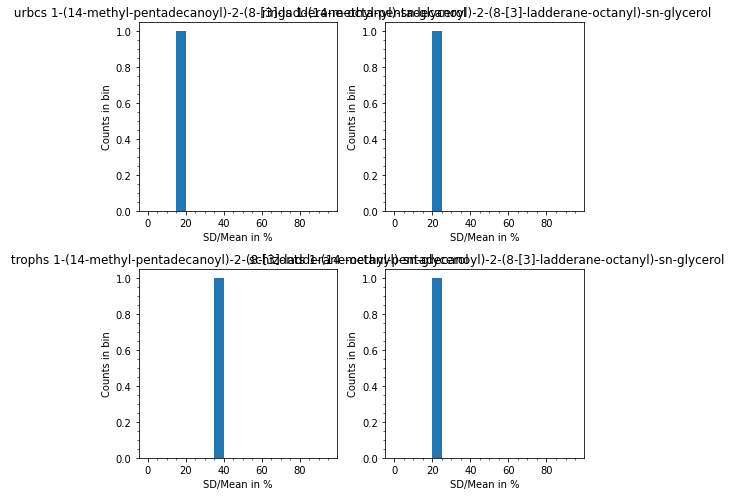

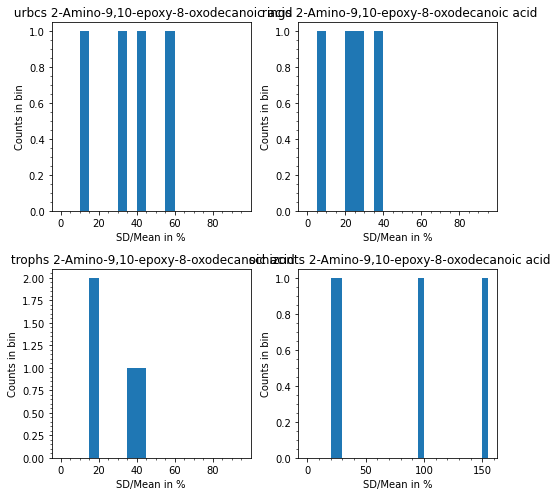

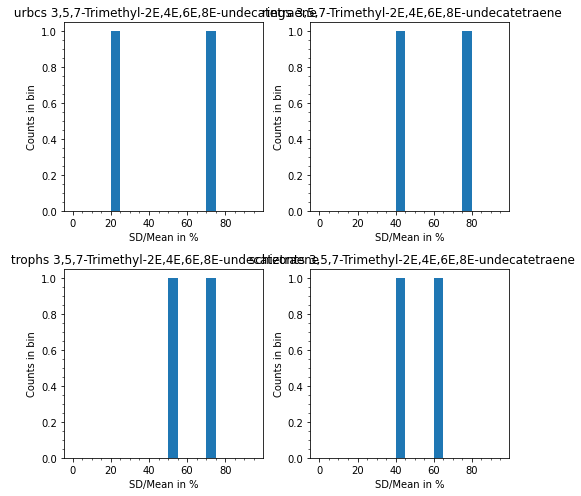

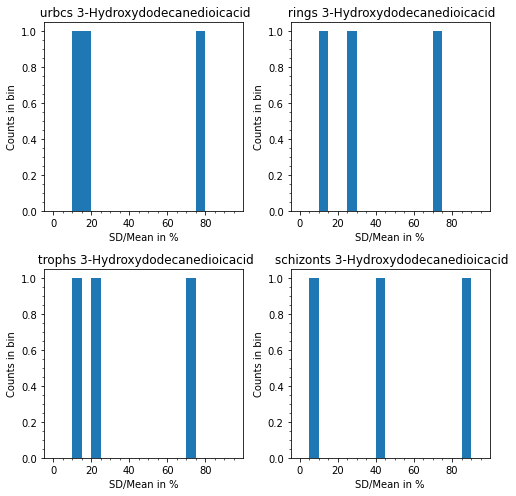

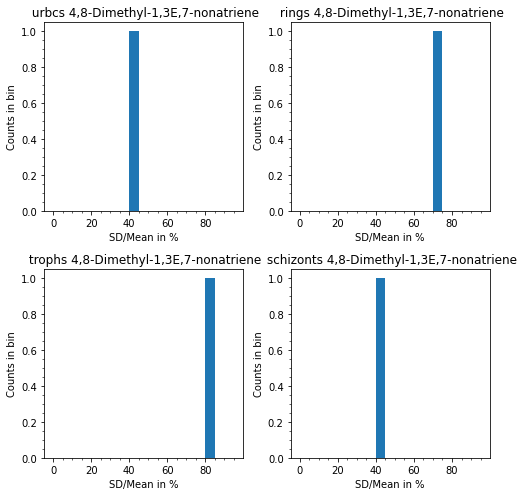

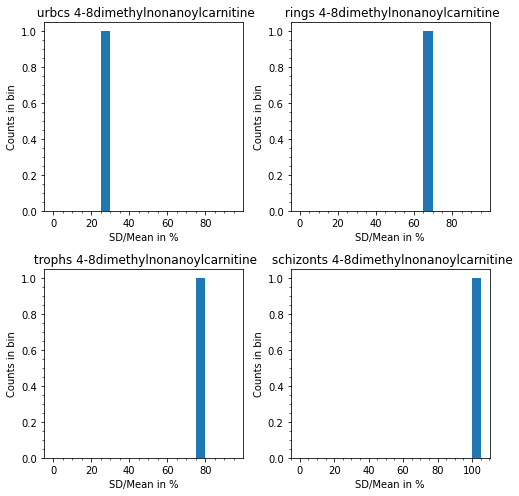

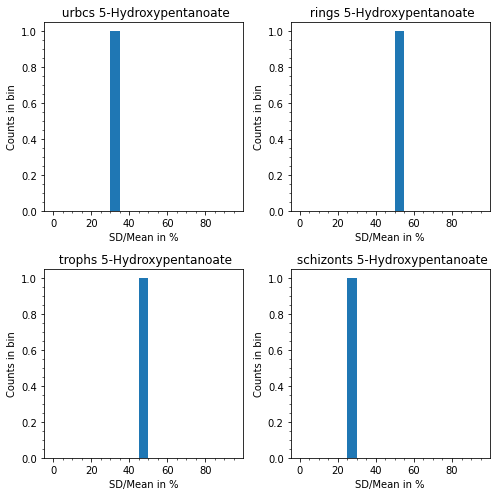

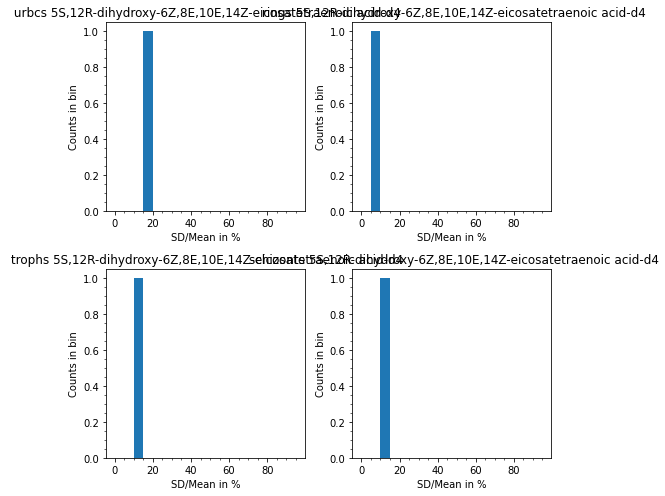

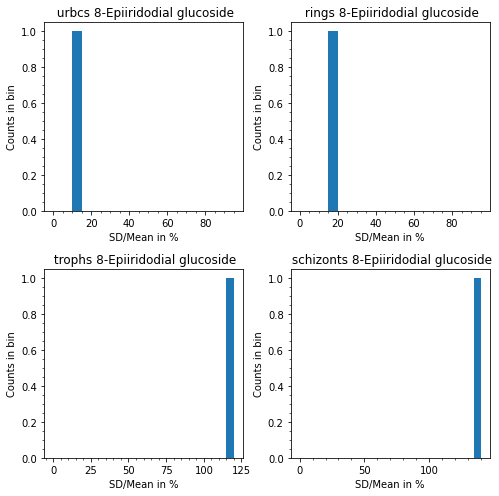

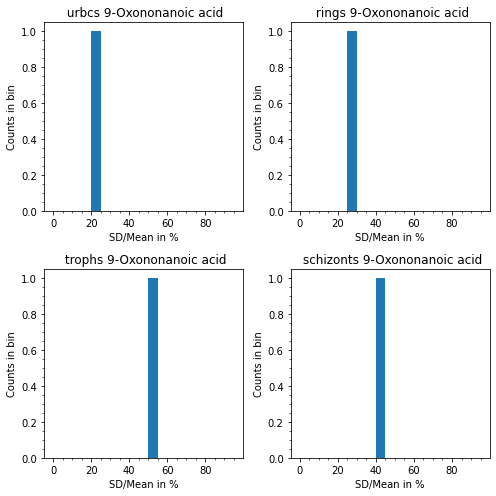

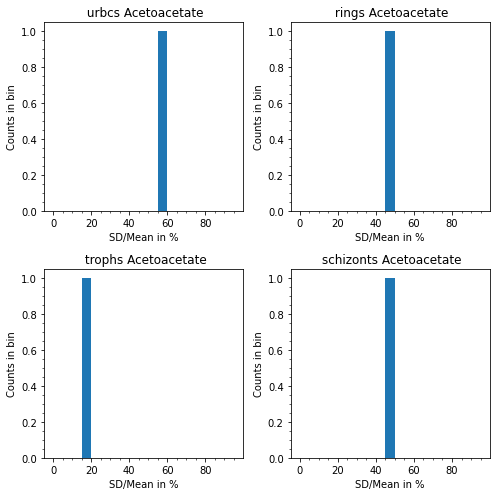

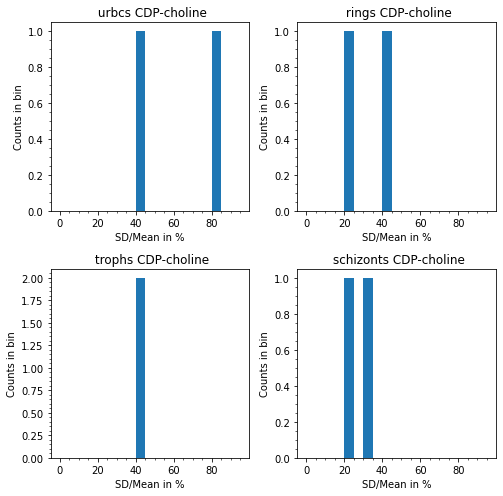

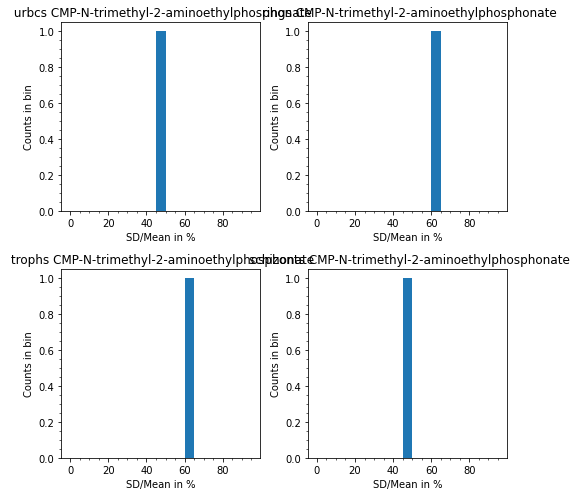

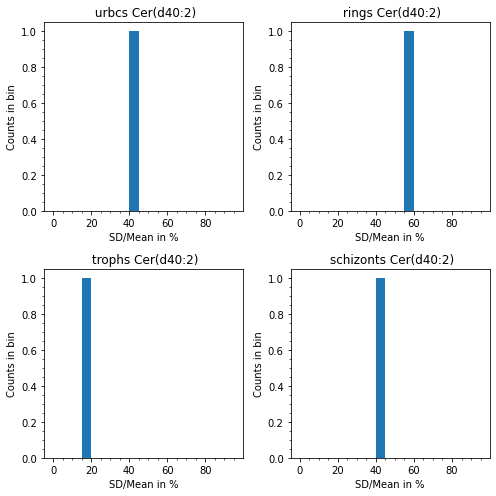

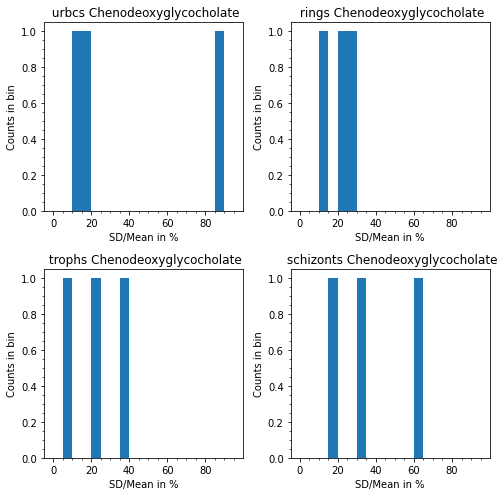

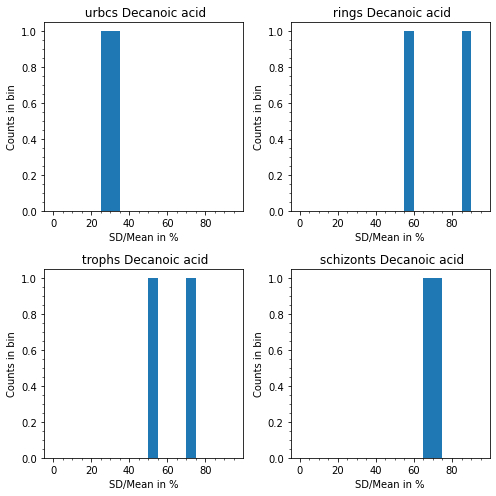

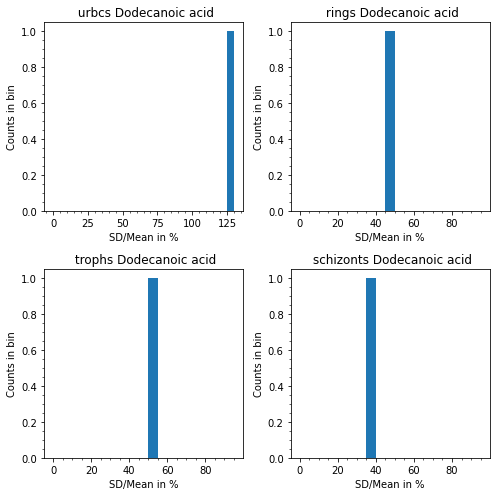

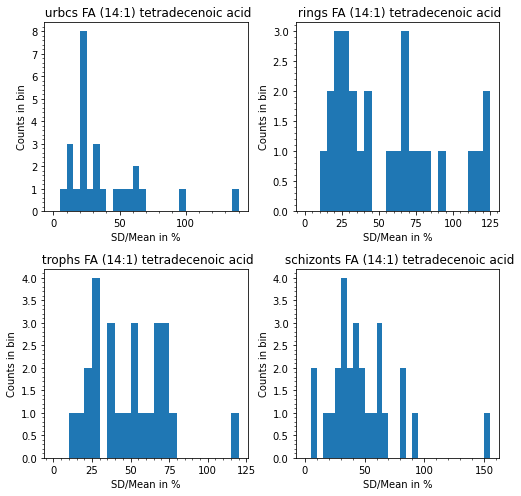

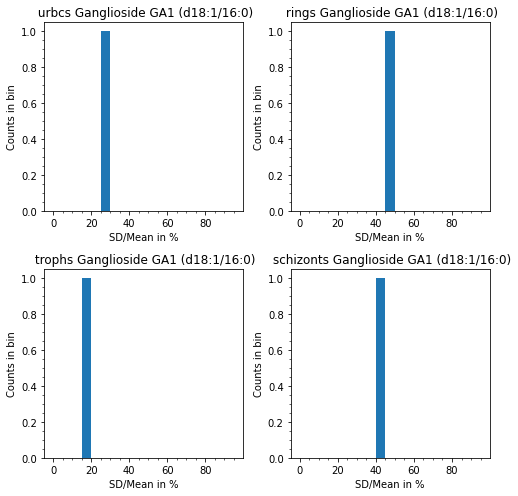

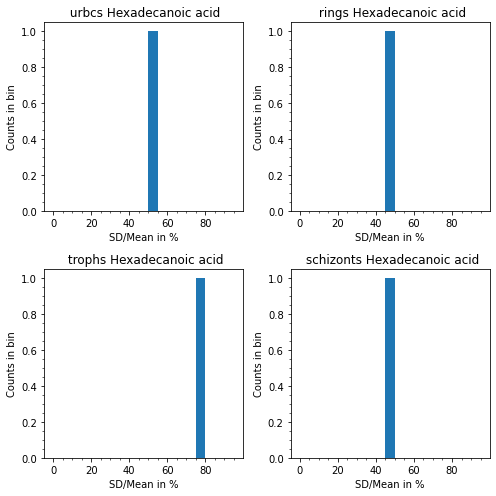

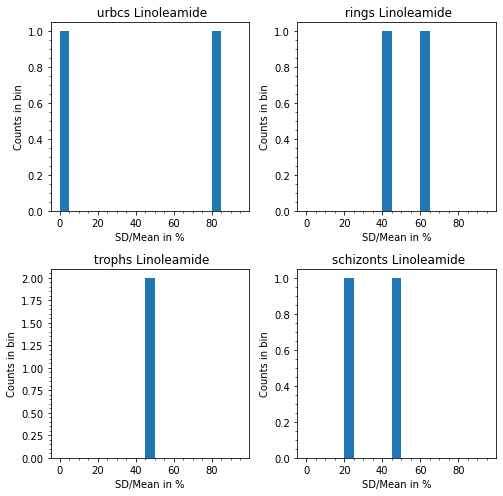

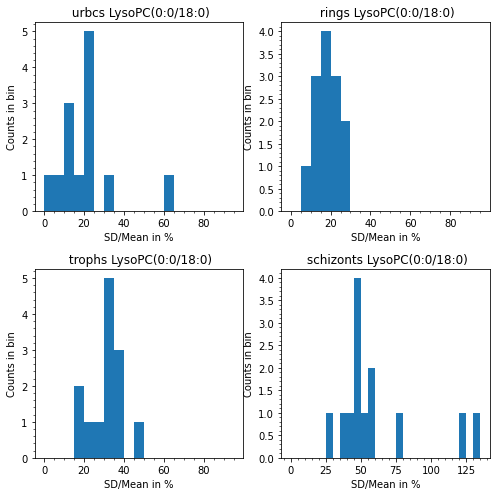

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


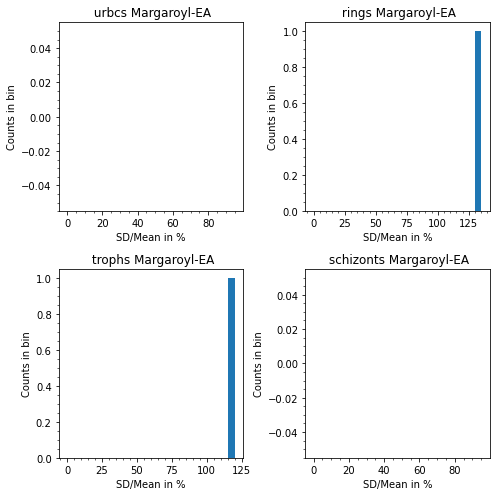

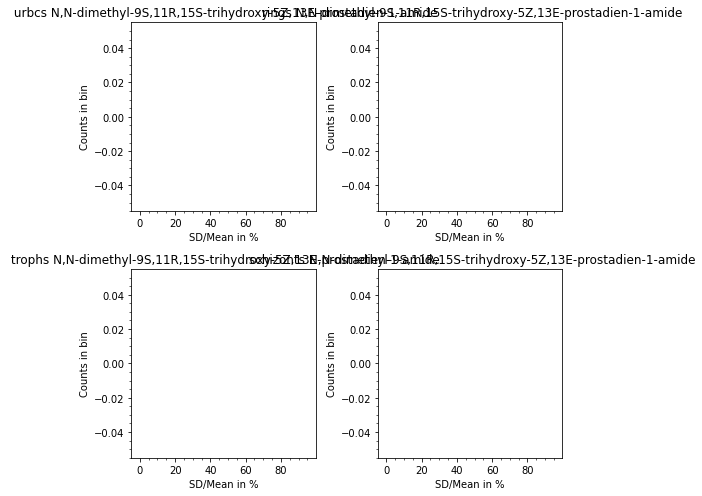

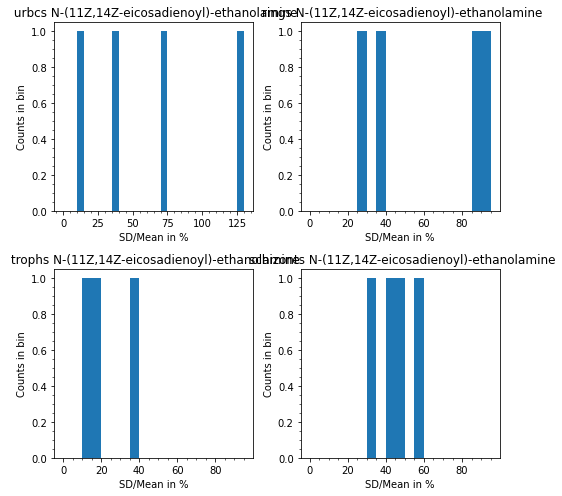

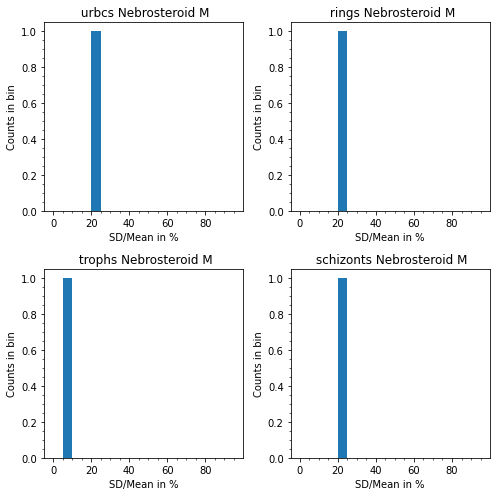

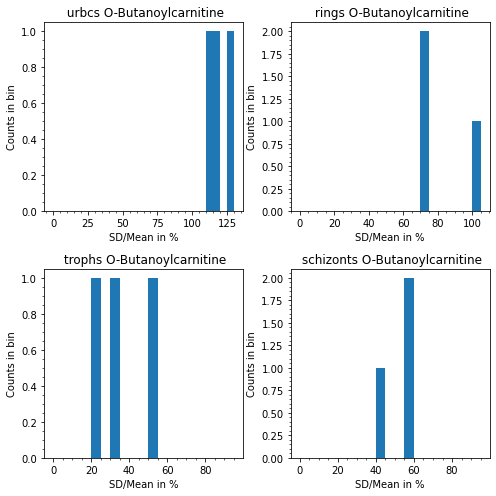

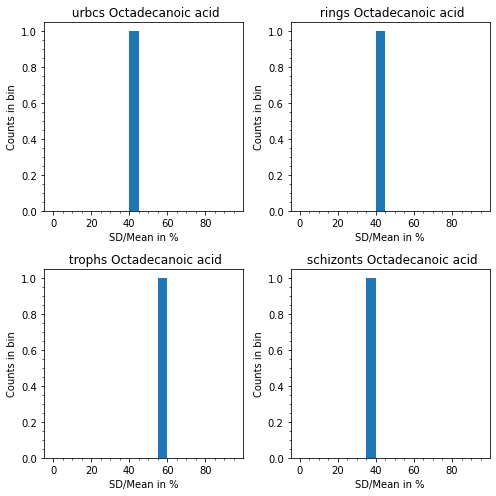

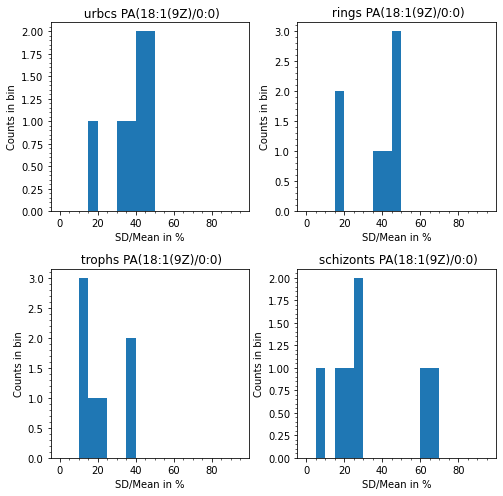

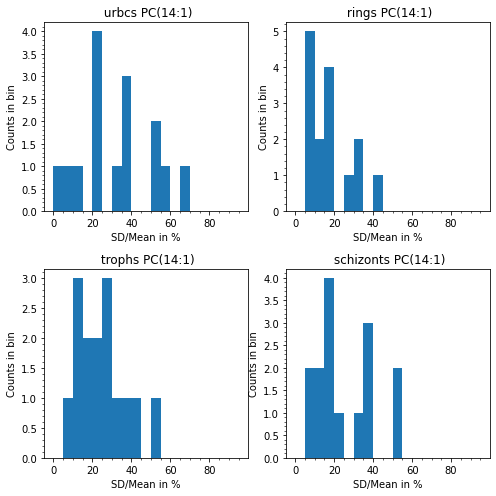

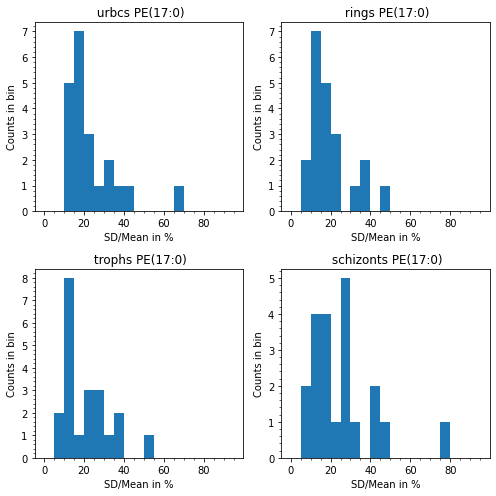

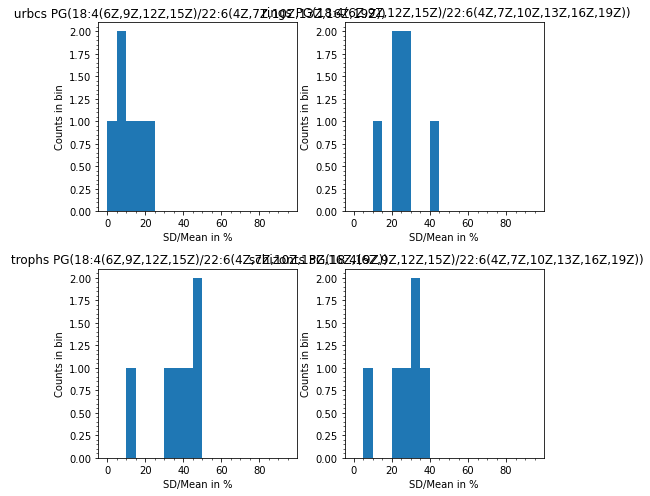

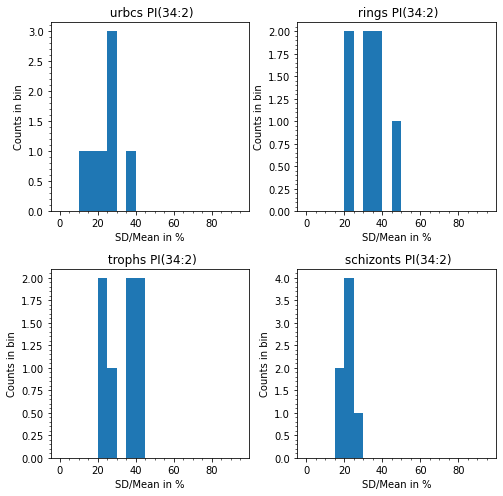

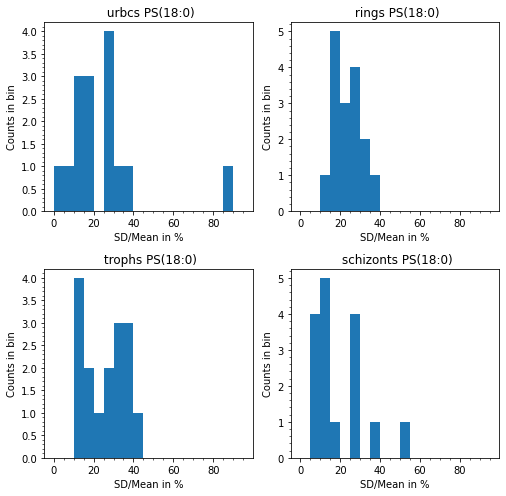

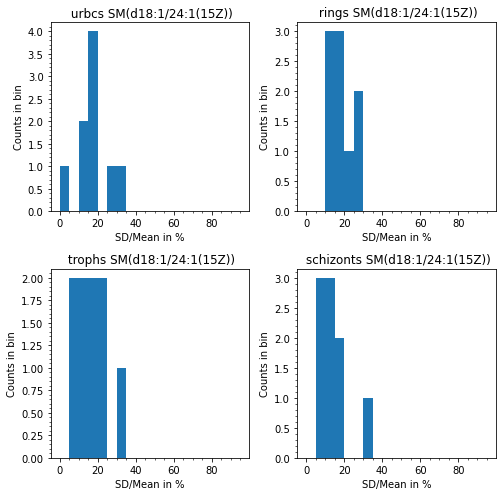

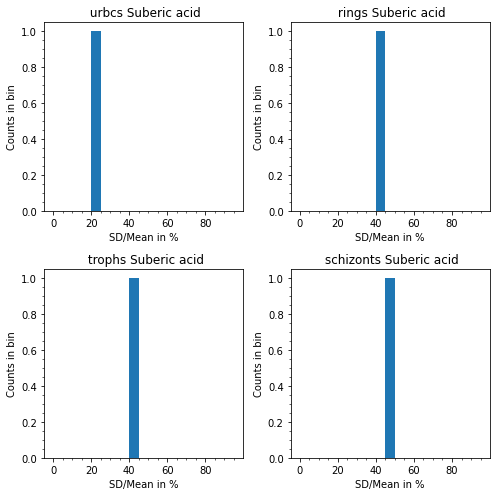

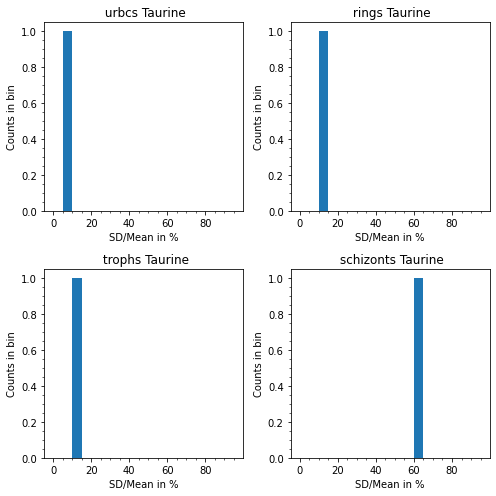

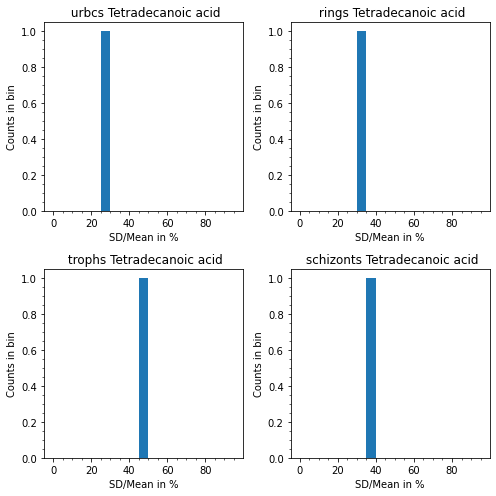

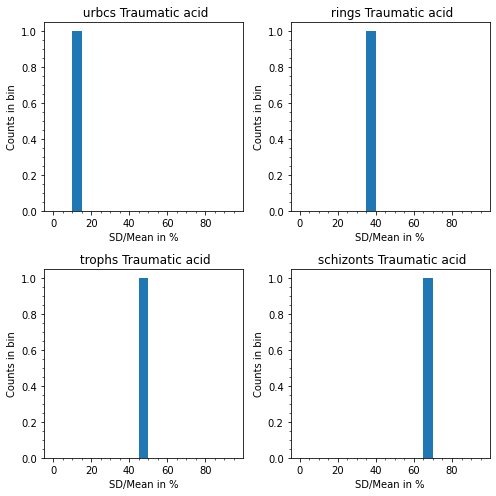

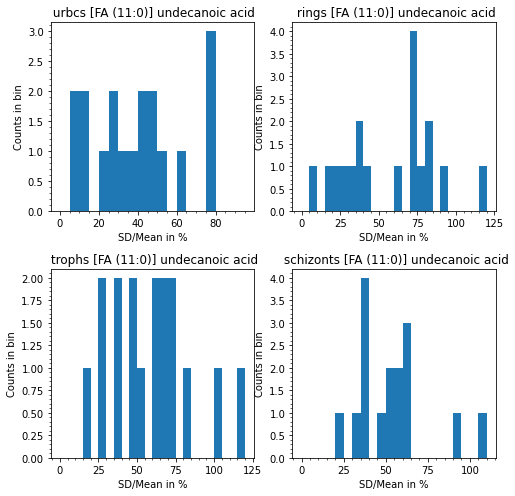

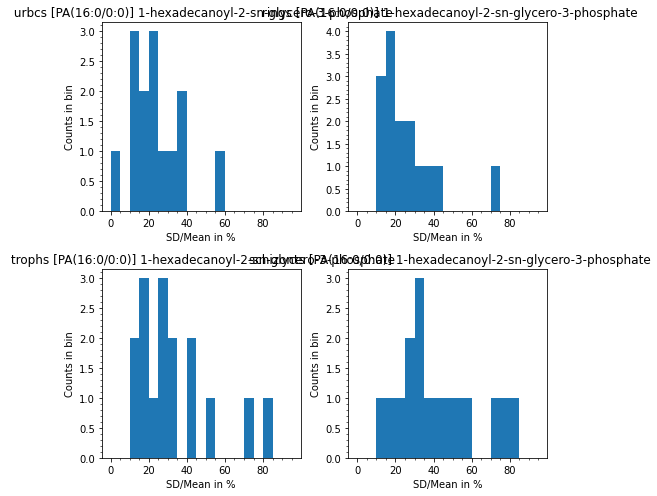

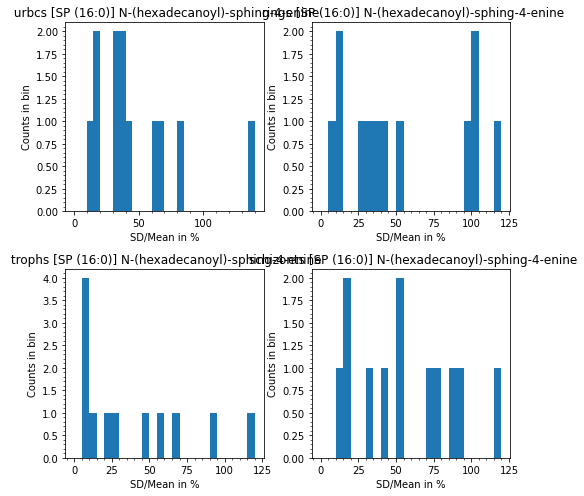

In [16]:
# Coefficient of Variation (CV)
for step in range(len(index_classes)-1):
    df = df_gs_lip.iloc[index_classes[step]:index_classes[step+1]].copy()
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
    
    metas = df['Putative metabolite'].to_list()
    for i, name  in enumerate(['Mean: urbcs','Mean: rings', 'Mean: trophs','Mean: schizonts']):
        phase = name[5:]
        std_str = 'SD'+ name[4:] 
        data = df[std_str]/df[name]
        maxium = 100
        if maxium < max(data*100):
            maxium = max(data*100+5)
        bins = np.arange(0,maxium,5)
        try:
            _ = axs.flat[i].hist(data*100, bins=bins)
            _ = axs.flat[i].set_title(phase +' '+ metas[0][:])
        except:
            print('DIDNT WORK')
            pass
        
        _ = axs.flat[i].set_xlabel('SD/Mean in %')
        _ = axs.flat[i].set_ylabel('Counts in bin')
        _ = axs.flat[i].minorticks_on()
    fig.tight_layout()
    plt.show()
    plt.close()

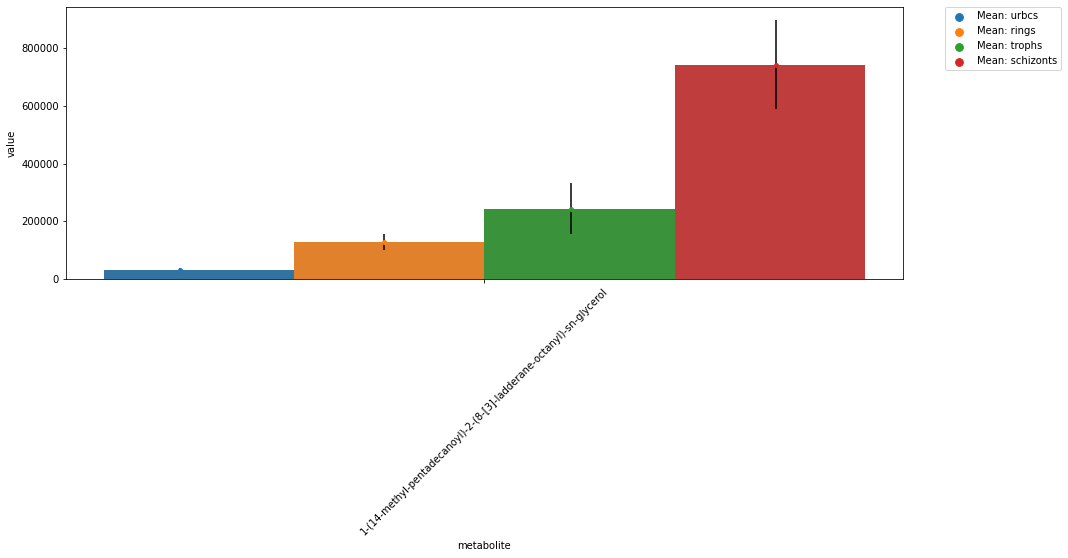

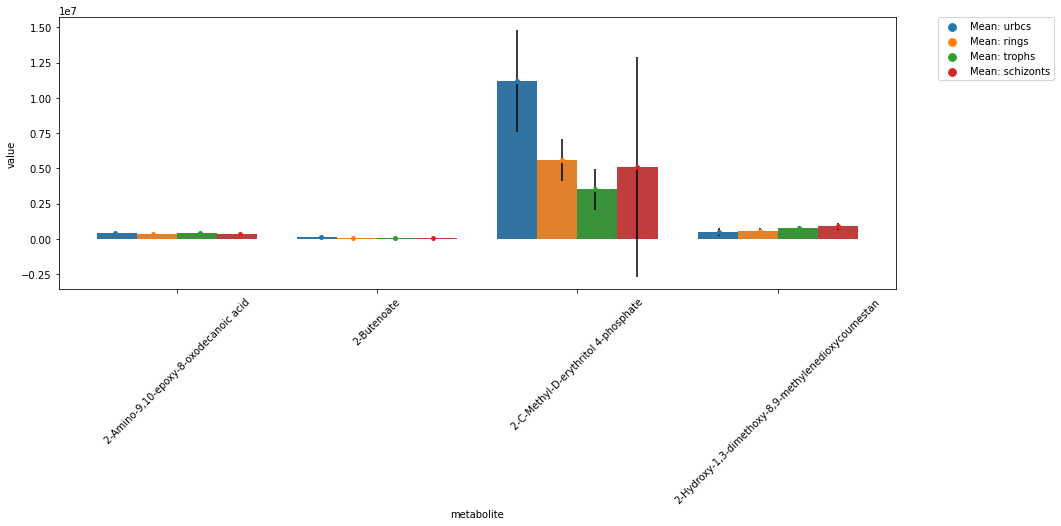

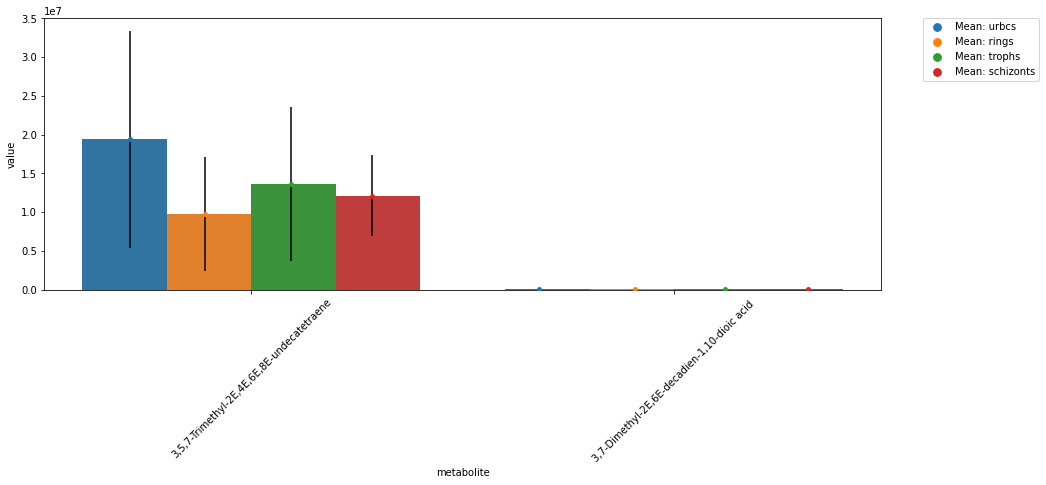

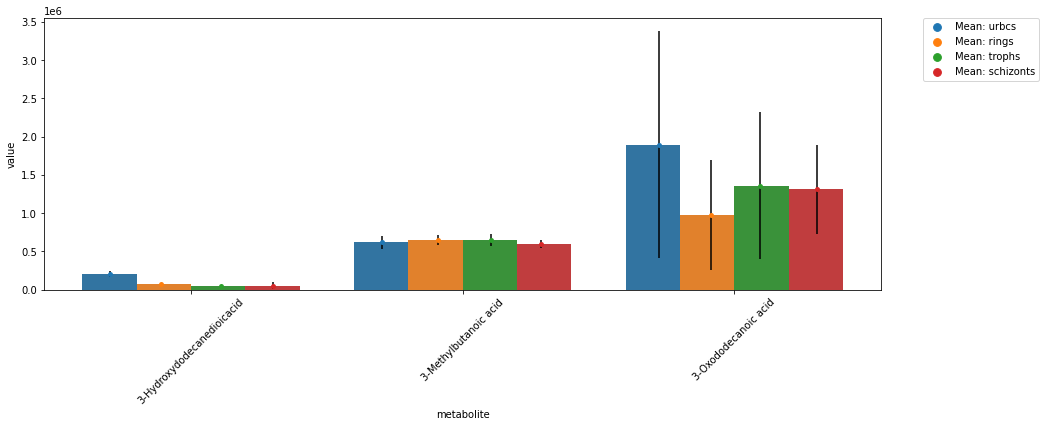

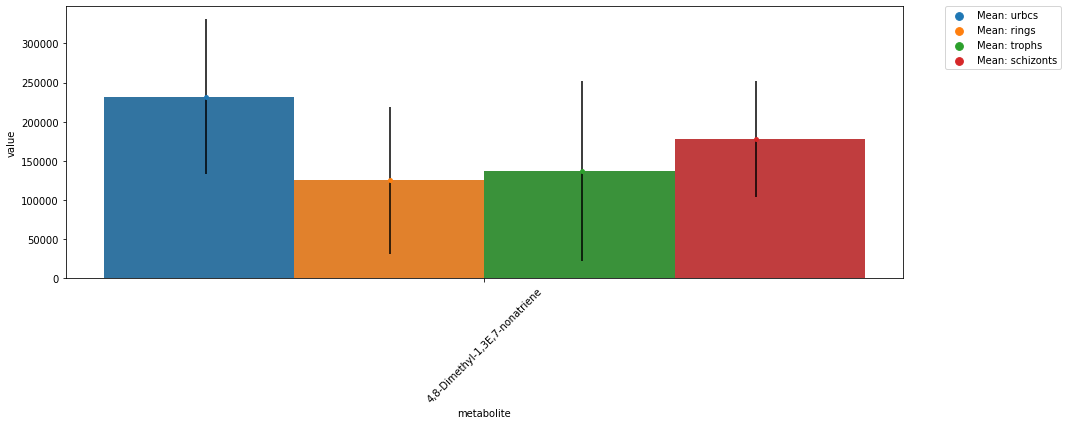

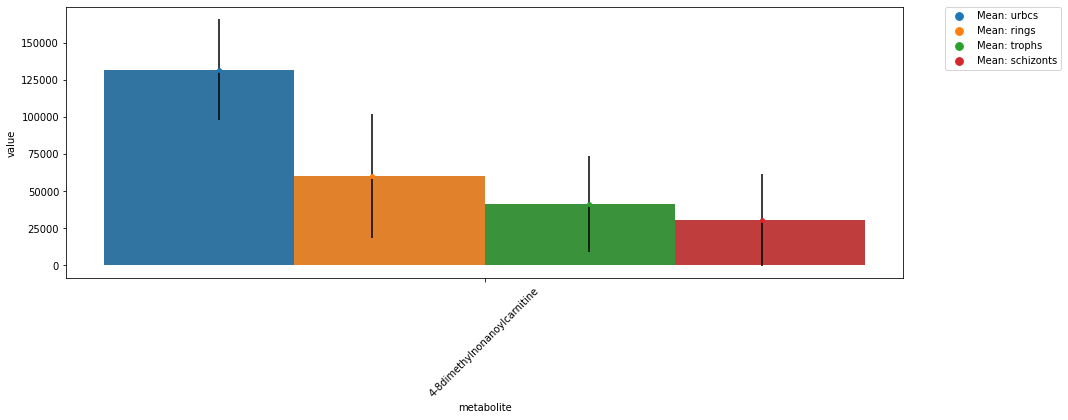

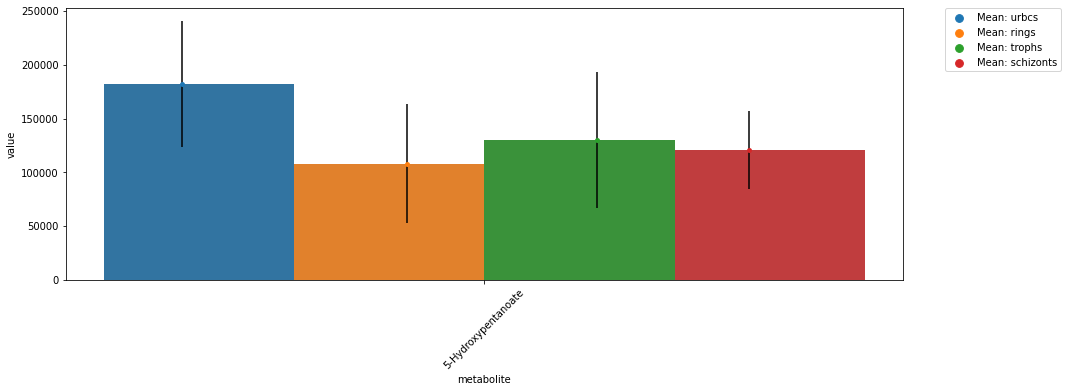

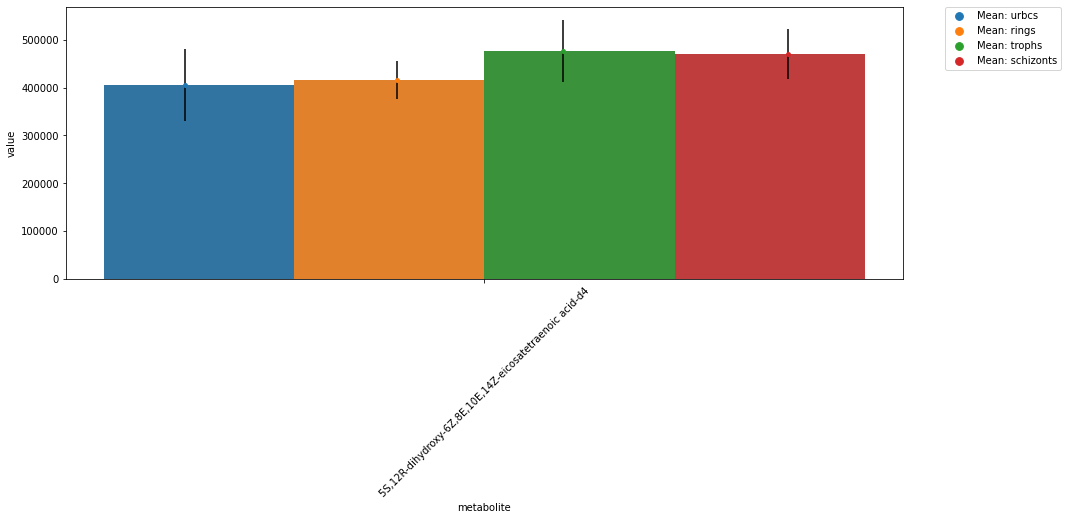

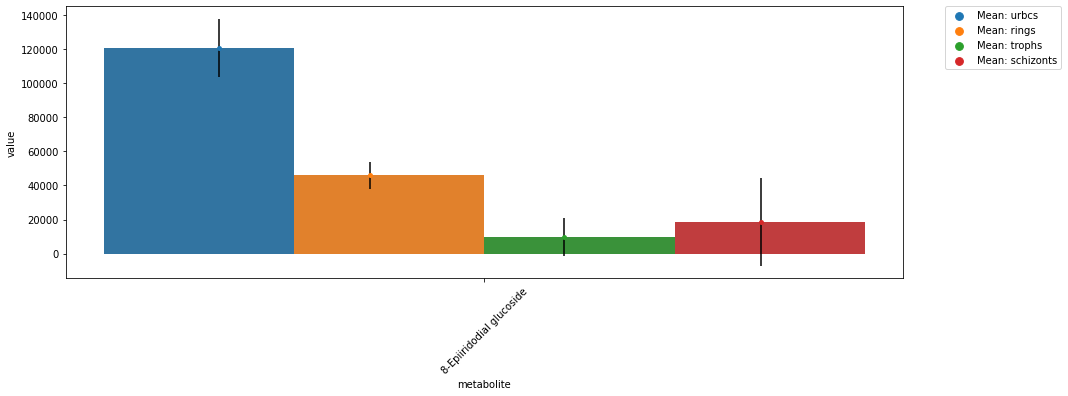

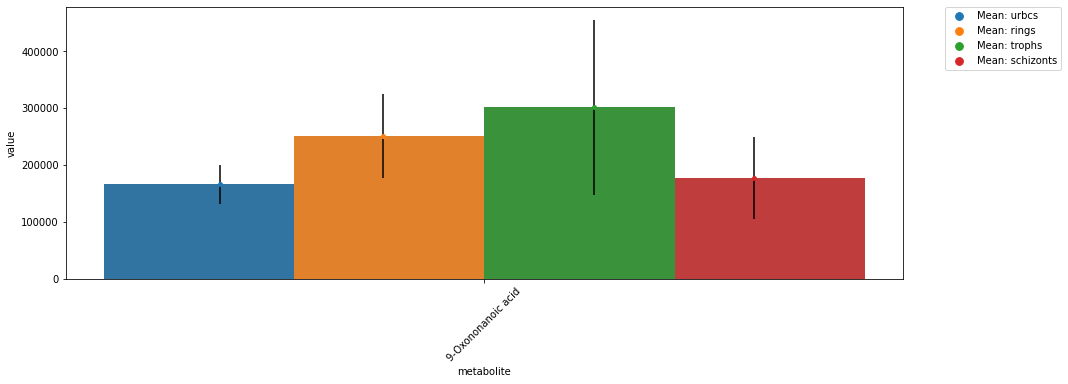

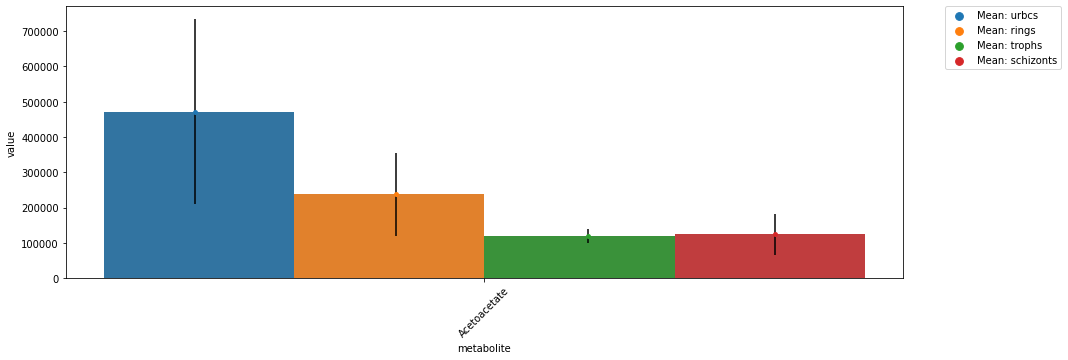

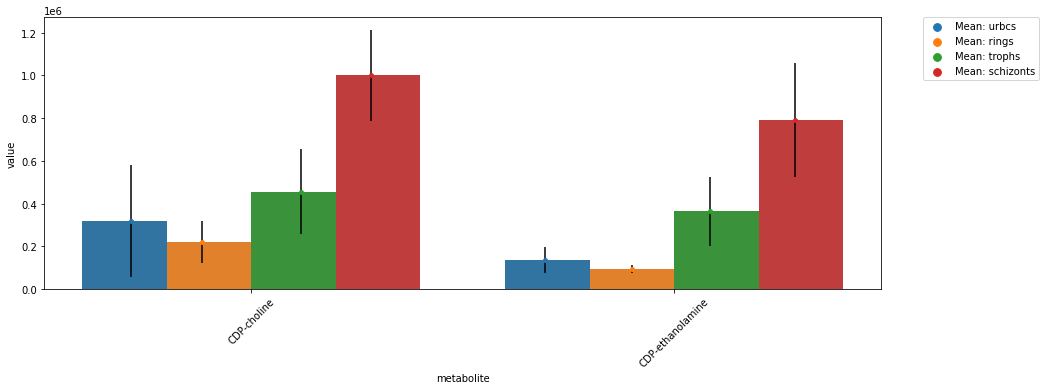

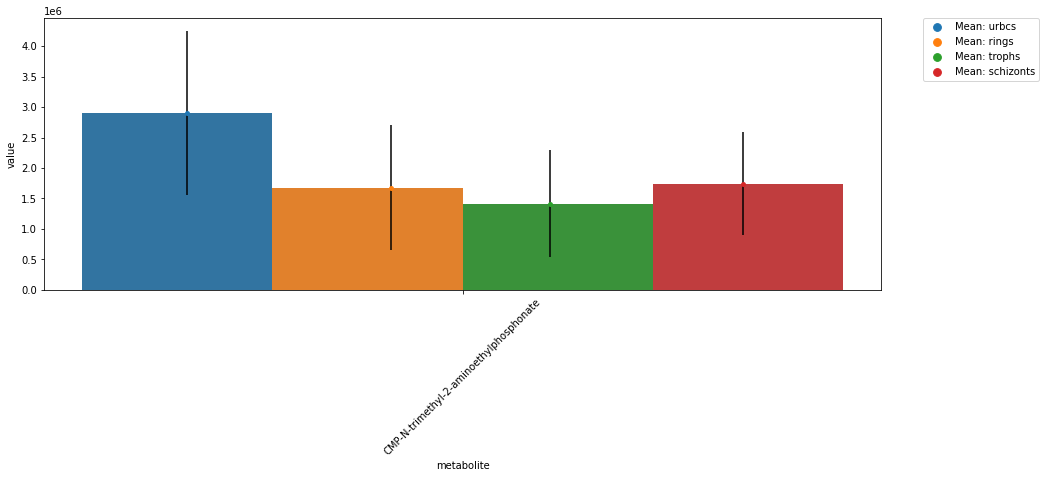

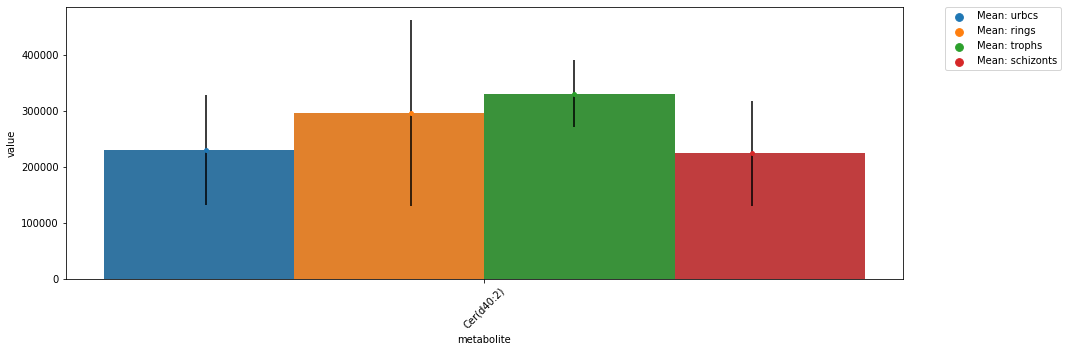

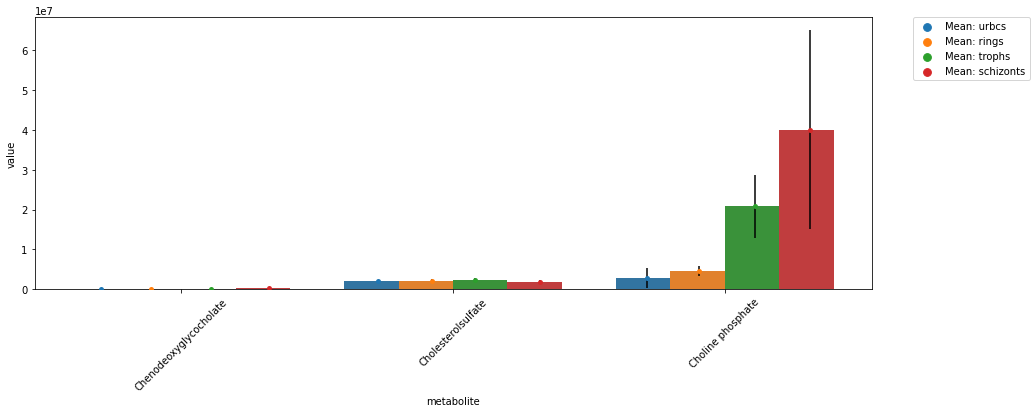

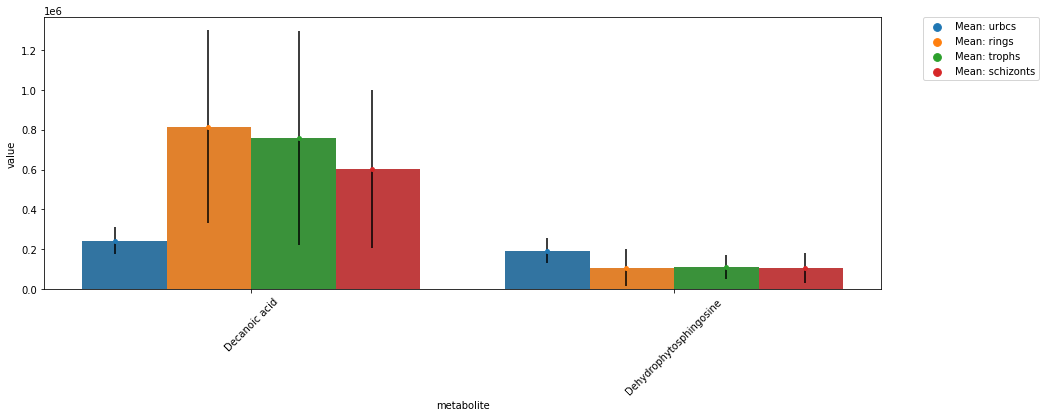

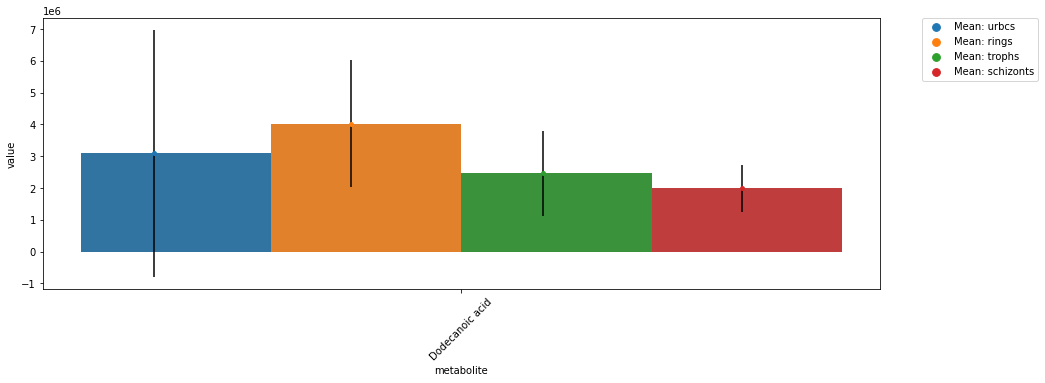

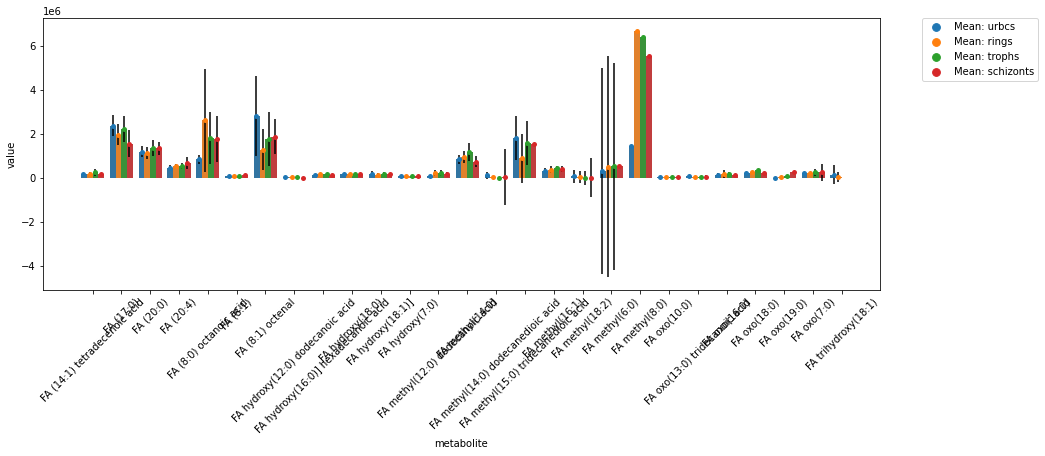

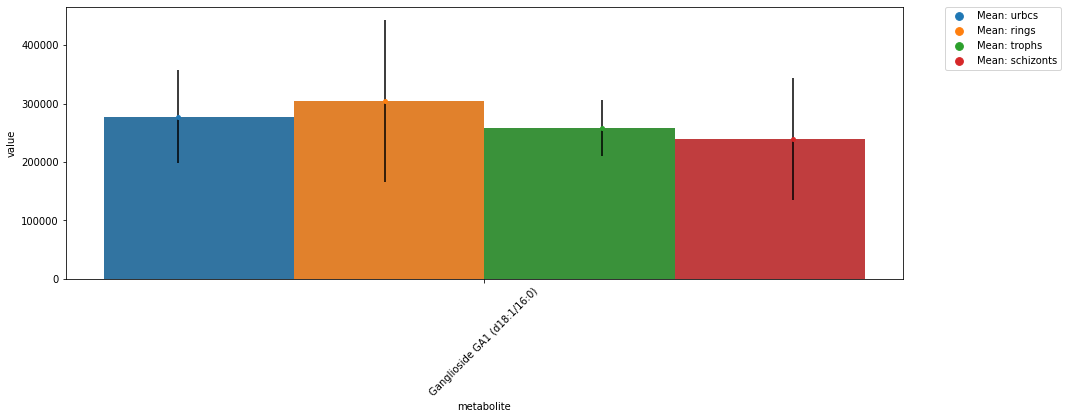

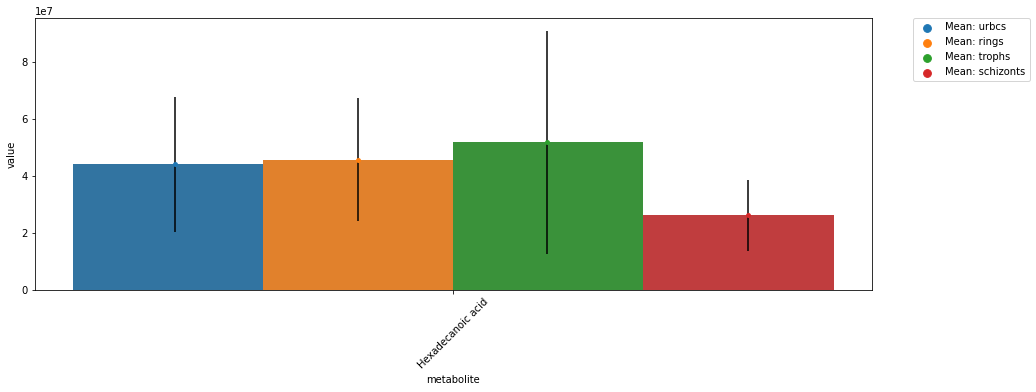

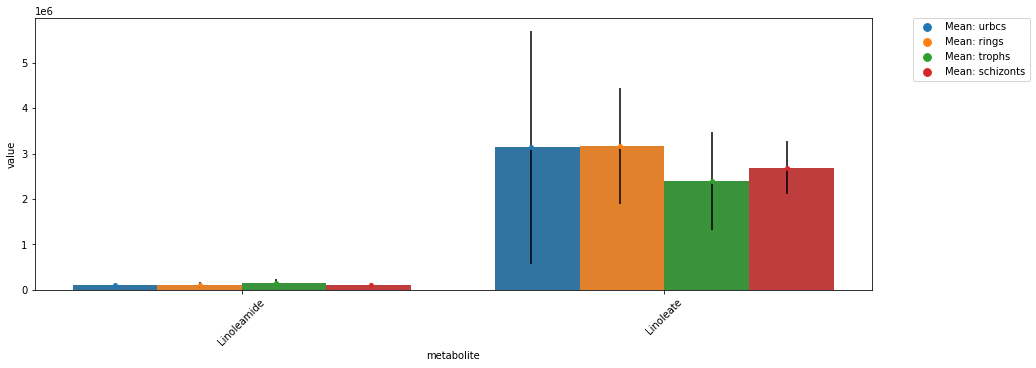

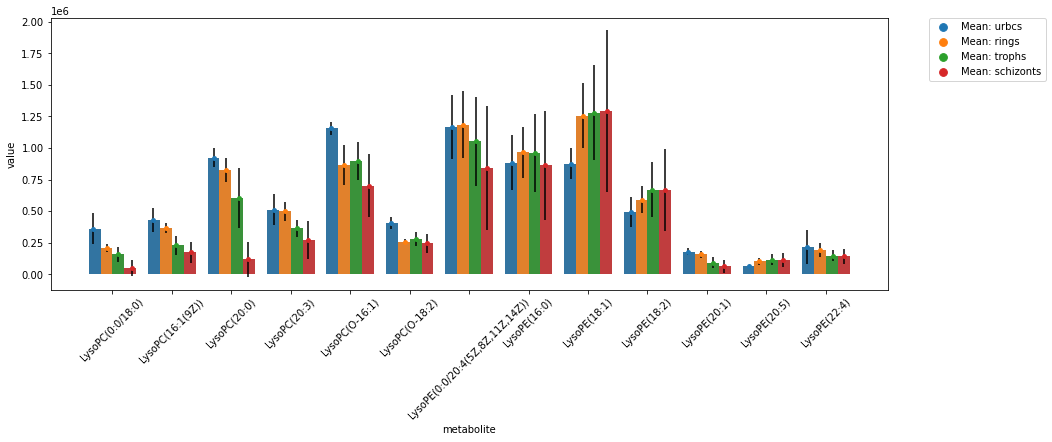

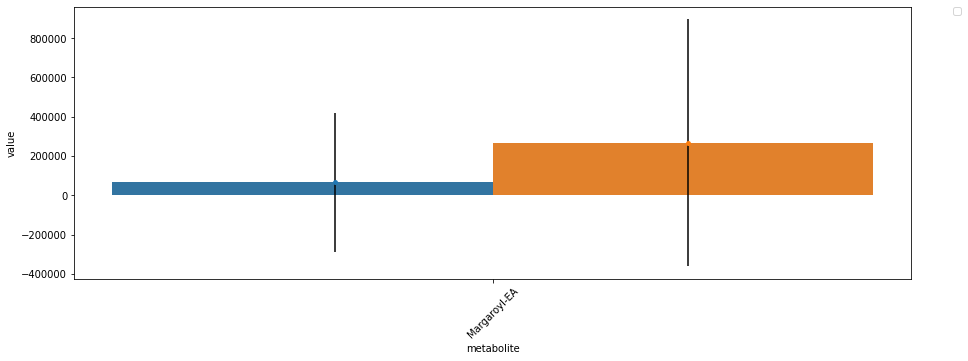

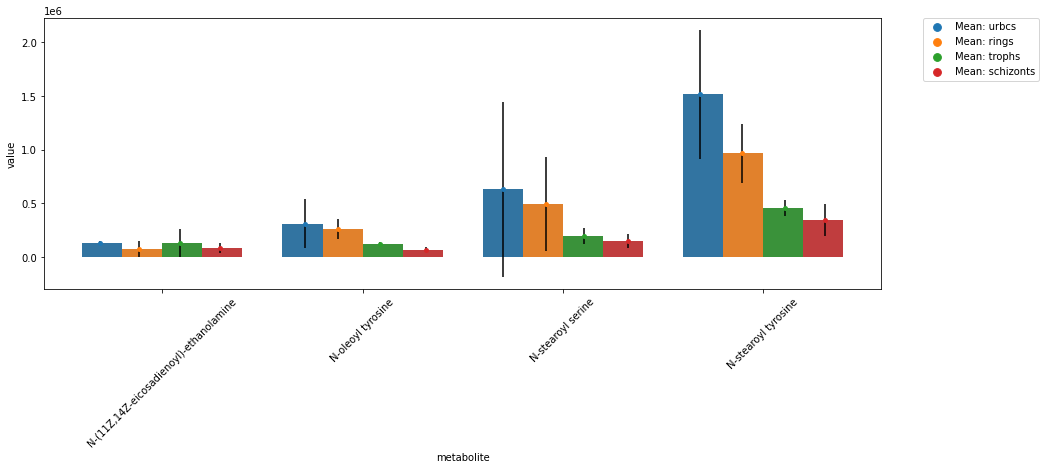

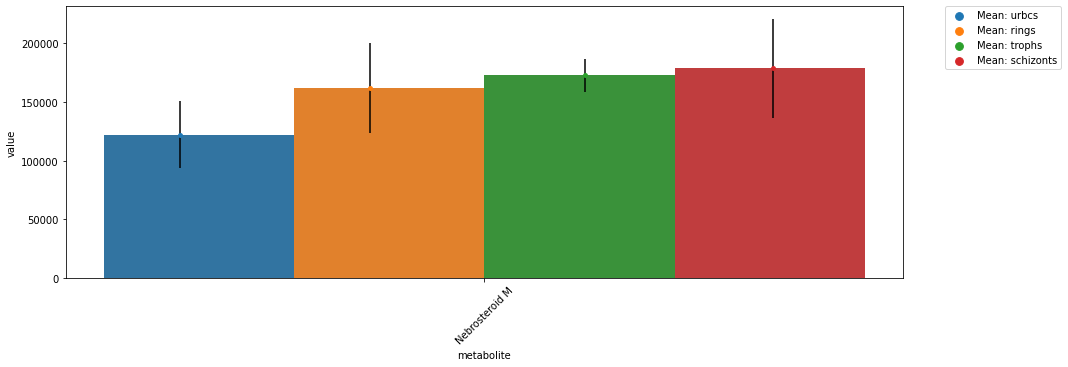

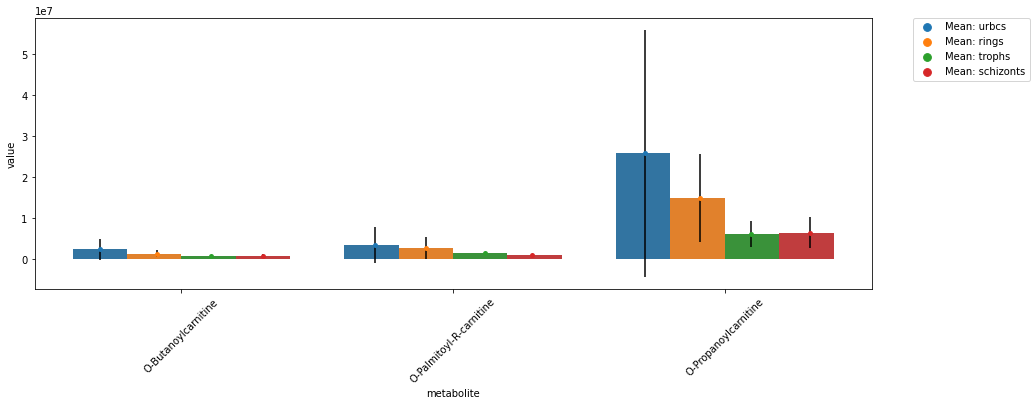

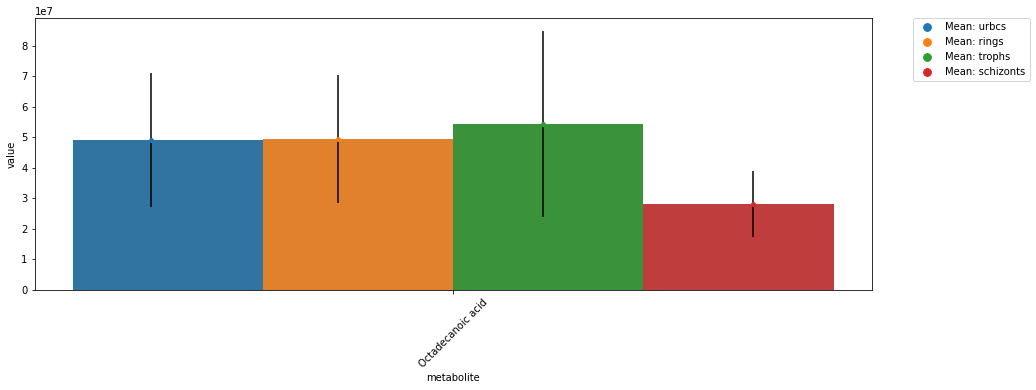

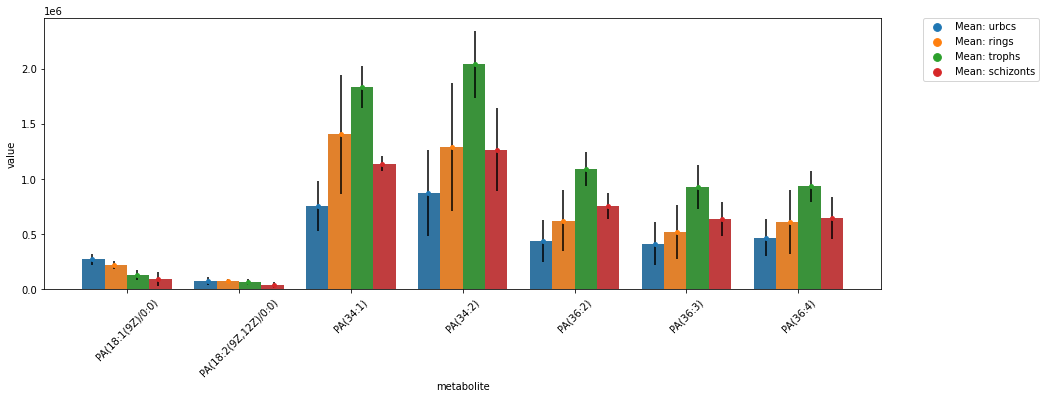

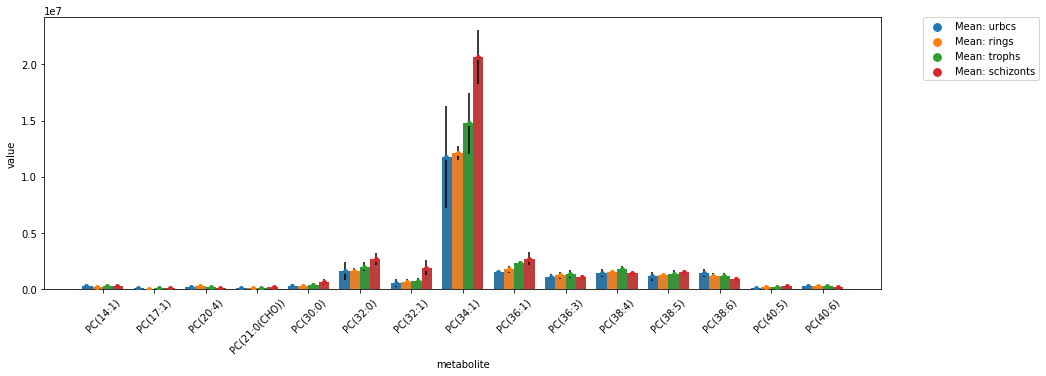

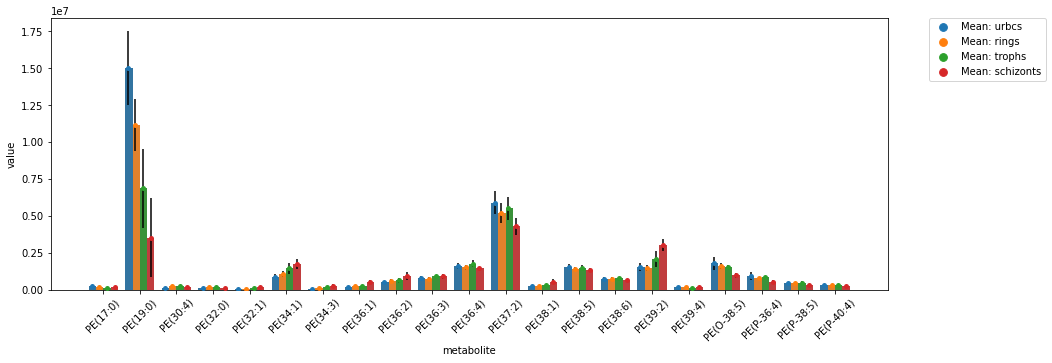

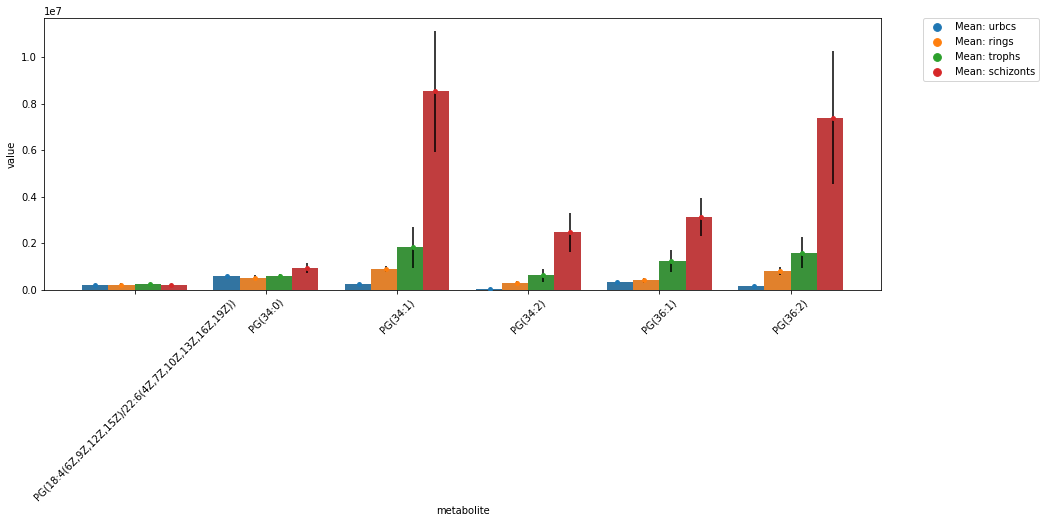

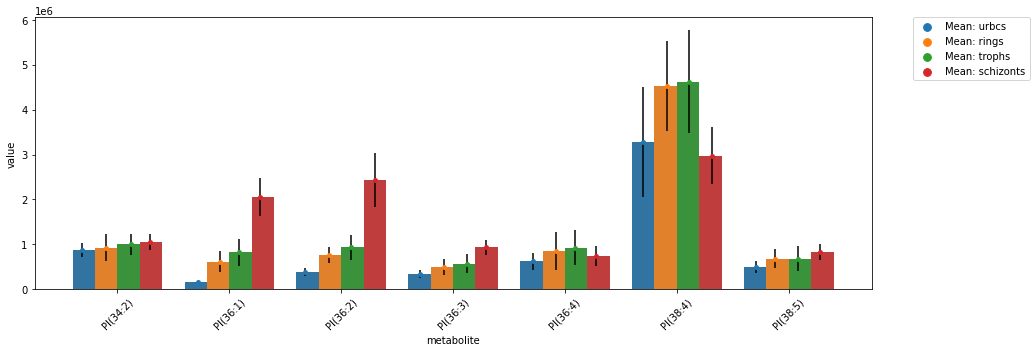

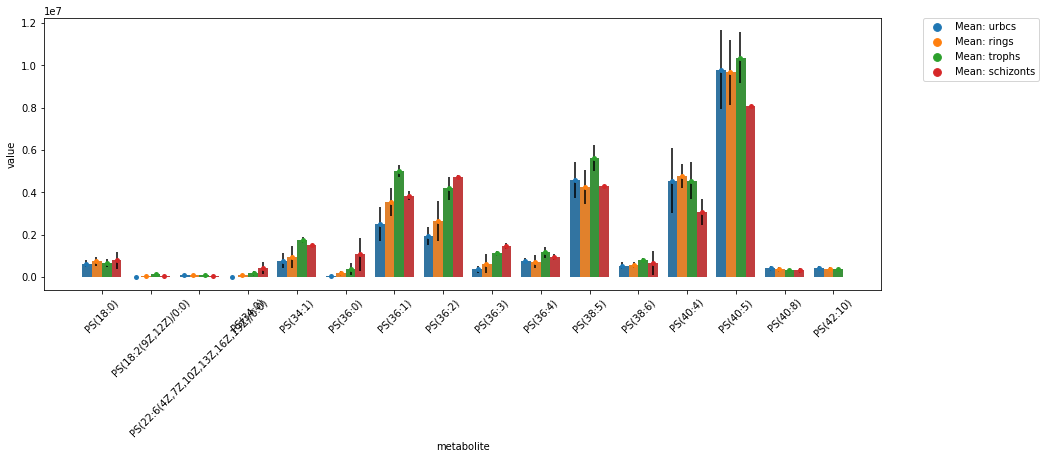

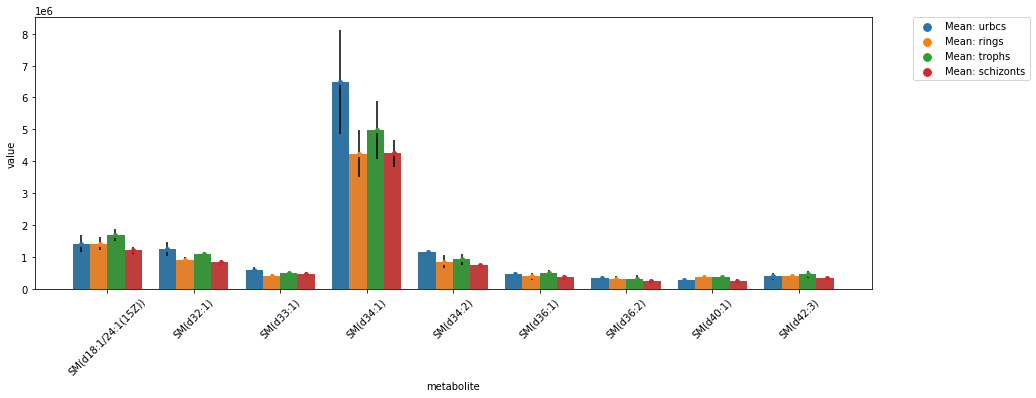

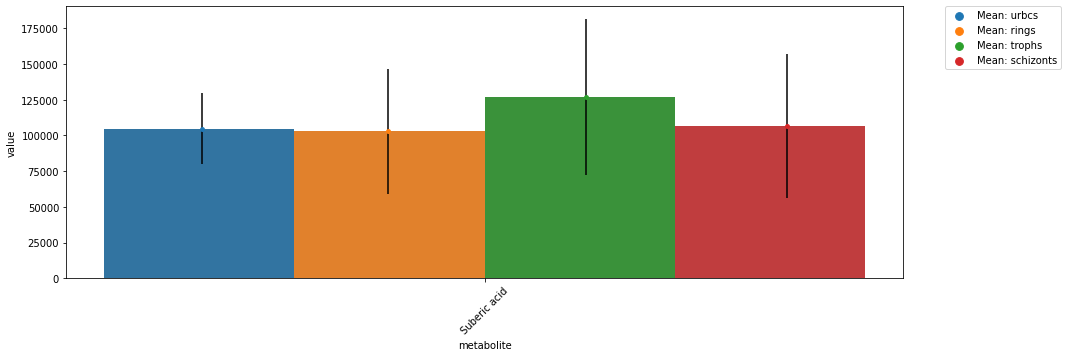

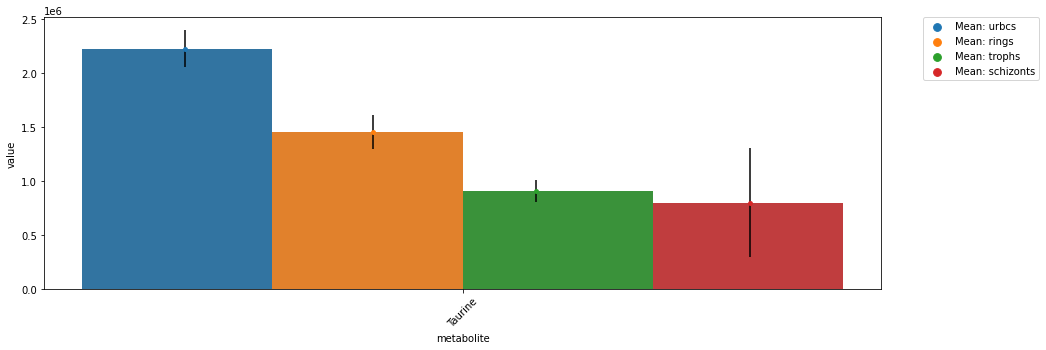

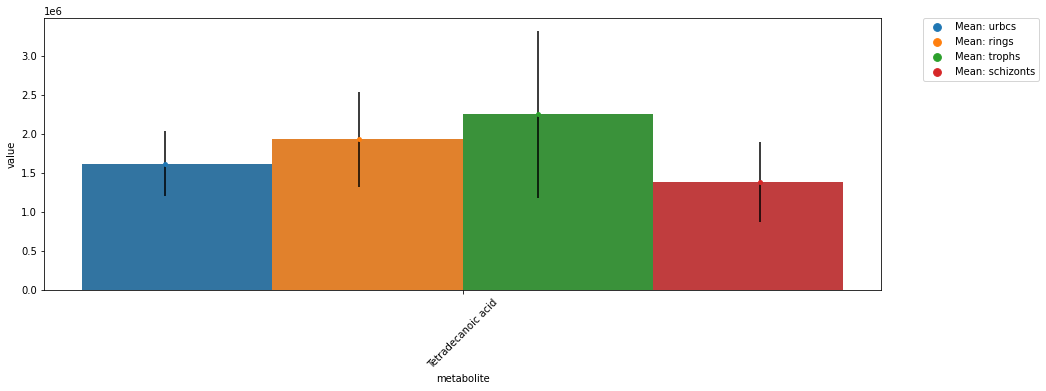

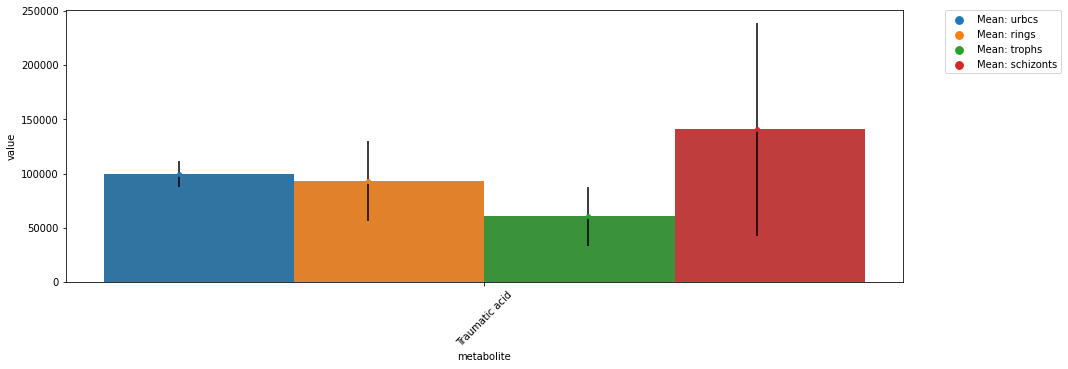

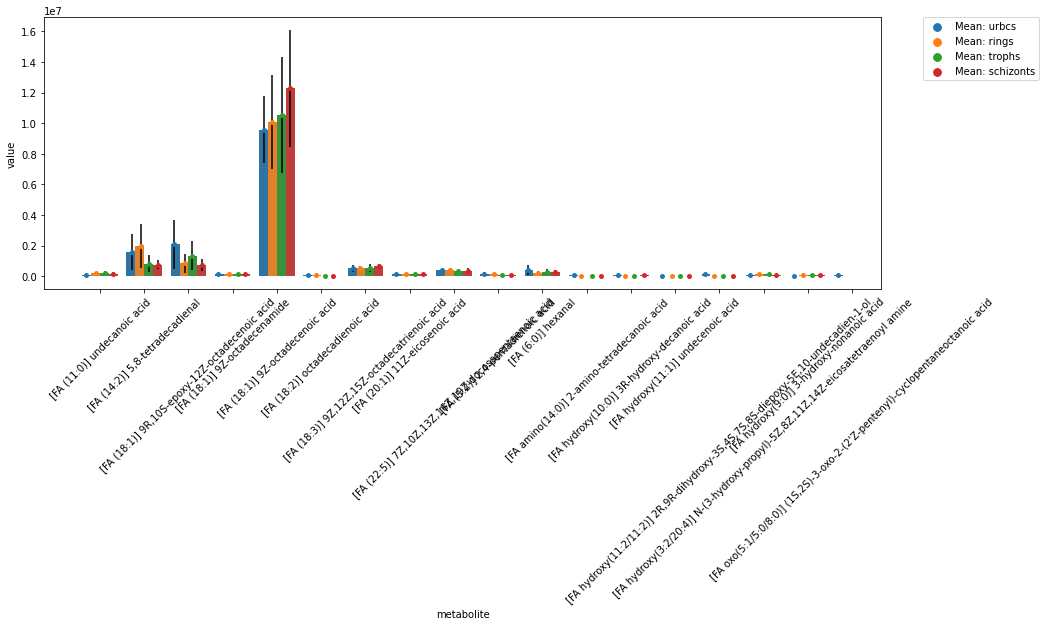

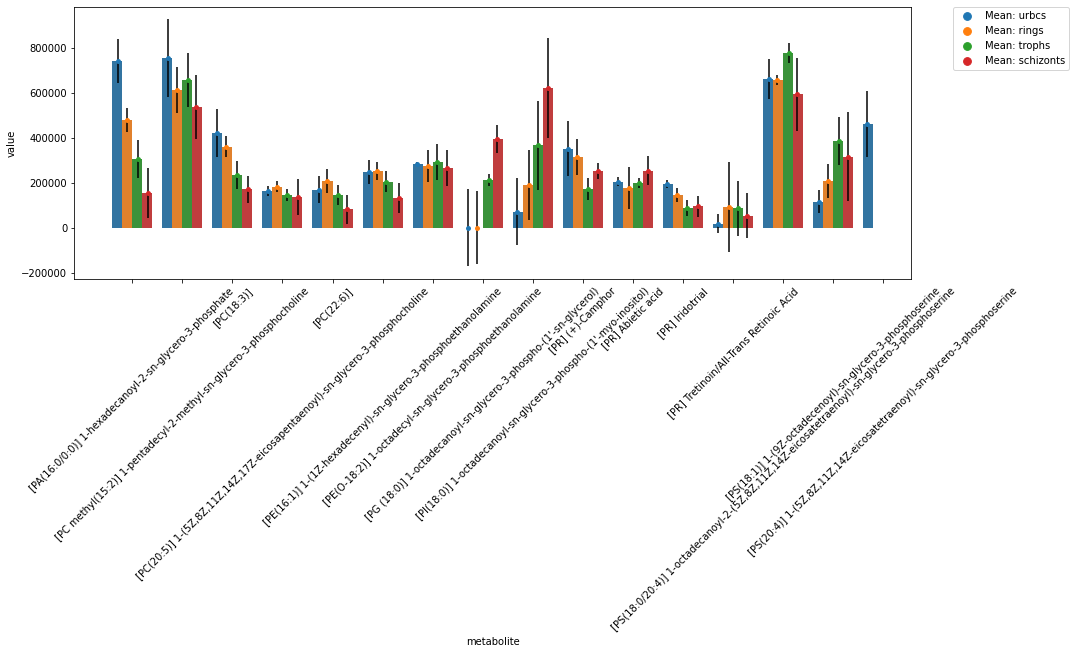

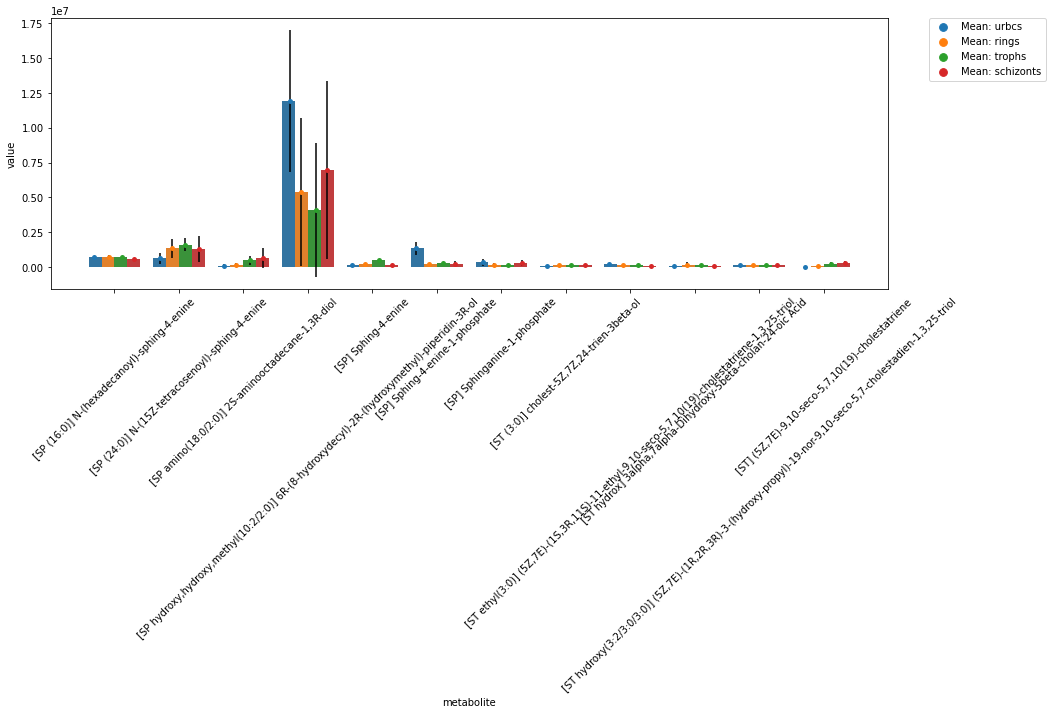

In [17]:
data_names =['Mean: urbcs','Mean: rings',
             'Mean: trophs','Mean: schizonts',
             ]
sd_names = ['SD: urbcs', 'SD: rings','SD: trophs',
            'SD: schizonts']
for step in range(len(index_classes)-1):
    
    df = df_gs_lip.iloc[index_classes[step]:index_classes[step+1]].copy()
    df.set_index('Putative metabolite', inplace=True)
    
    df2 = df.loc[:, data_names].stack().reset_index()
    df2.columns = ['metabolite', 'Phase','value']
    
    dfsd = df.loc[:, sd_names].stack().reset_index()
    dfsd.columns = ['metabolite', 'Phase','SD']
    
    df2 = df2.join(dfsd['SD'],how='right')
    
    if df2.empty:
        continue
    fig, ax = plt.subplots(figsize=(15,5))
    
    _ = sns.barplot(x="metabolite", y="value",
                    hue="Phase", data=df2)
    
    _ = sns.stripplot(x="metabolite", y="value",
                      hue="Phase", data=df2, dodge=True)
    # Find the x,y coordinates for each point
    x_coords = []
    y_coords = []
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)

    # Calculate the type of error to plot as the error bars
    # Make sure the order is the same as the points were looped over
   
    errors = df2['SD']
    ax.errorbar(x_coords, y_coords, yerr=errors, 
                color='black', fmt=' ')
    
    handles, labels = _.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the last two.
    l = plt.legend(handles[:-4], labels[0:-4], 
                   bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=45)
    plt.show()
    plt.close()

## Lipid graph output comments:
- CDP-Cho and CDP-Etn lower in ring phase then uRBC but rises to higher levels(3x in Schizonts)
- Ceramide(only on species in datad set) first rises until troph then falls to similar value as uRBC
- Cho-P rises to high level in schizont(looks exponential)
- decanoic acid high level in ring and then drops linear to schizont still higher than ring tho
- dodeacnoic similar but schizont value lower than uRBCS
- FA graph has to be remade but no general pattern for all 
- Lyso-PE most Species fall except for 16:0, 18:1, 18:2. The 18:x have a distinct higher level but SD makes hard to be certain
- PA lyso forms fall, other PA all similar curve peak at troph then fall to a level in schizont that is higher than uRBC
- PC 34:1 very high level when compared to the other species, but it seems like 30:0 to 36:1 the species in general rise to peak in schizont phase, more unsaturated behaviour is complex mostly peak in troph but fall to levels lower than uRBCs

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import fcluster
%matplotlib inline

pd.options.display.max_columns = 99
df_gs = pd.read_excel('Rings-trophs-schizonts-metabolomics-GS.ods')
print(df_gs.columns)



In [18]:
def plot_clustermap(data:pd.DataFrame,
                    methods=['single', 'complete','average','weighted','centroid','median','ward'],
                    minmax_scale=True):
    X = data.values
    if minmax_scale:
        for i in range(len(X)):
            proxy = X[i]
            if proxy.sum()!=0:
                proxy = (proxy-proxy.min())/(proxy.max()-proxy.min())
            X[i] = proxy

    for meth in methods:   
        sns.clustermap(X, method=meth,
                       col_cluster=False,
                       cmap="viridis"
                       )
        plt.title(meth.capitalize(),position=(3.,0))
        plt.tight_layout()
        plt.show()
    return None

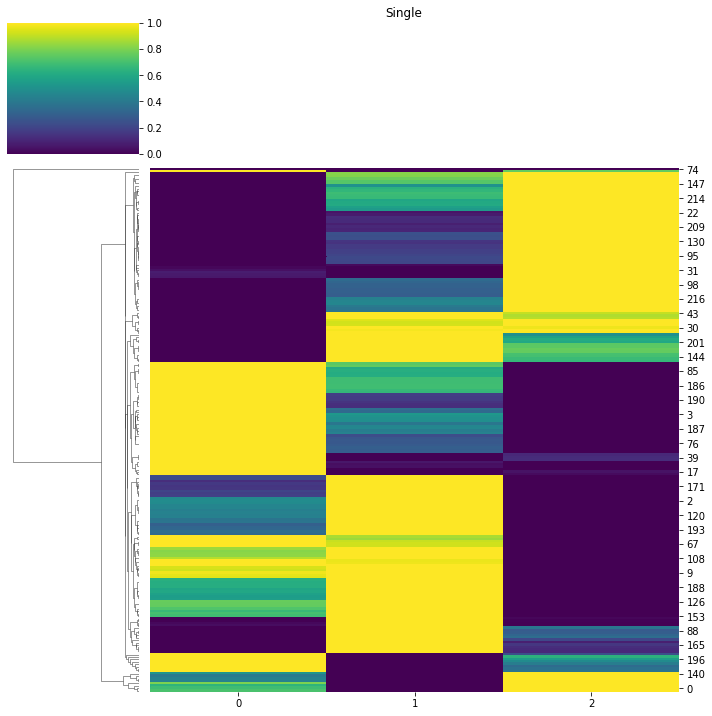

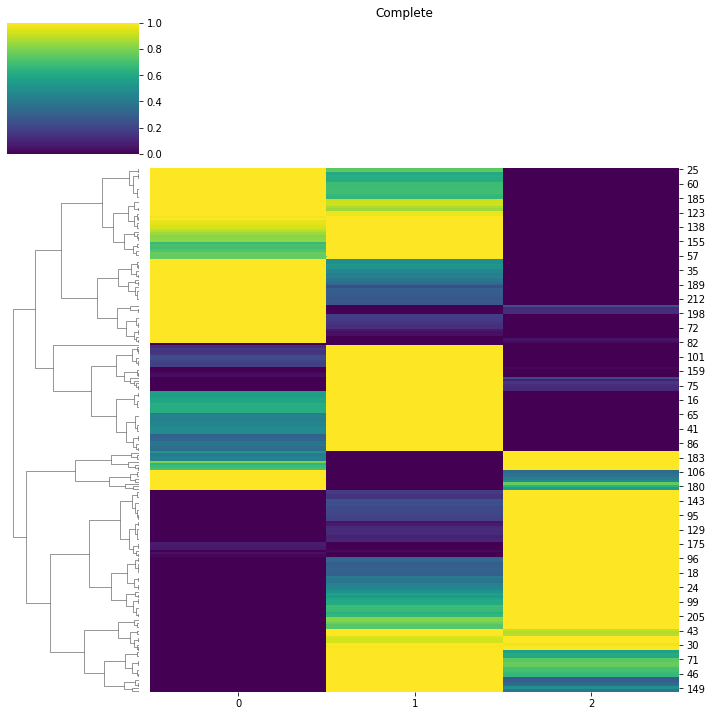

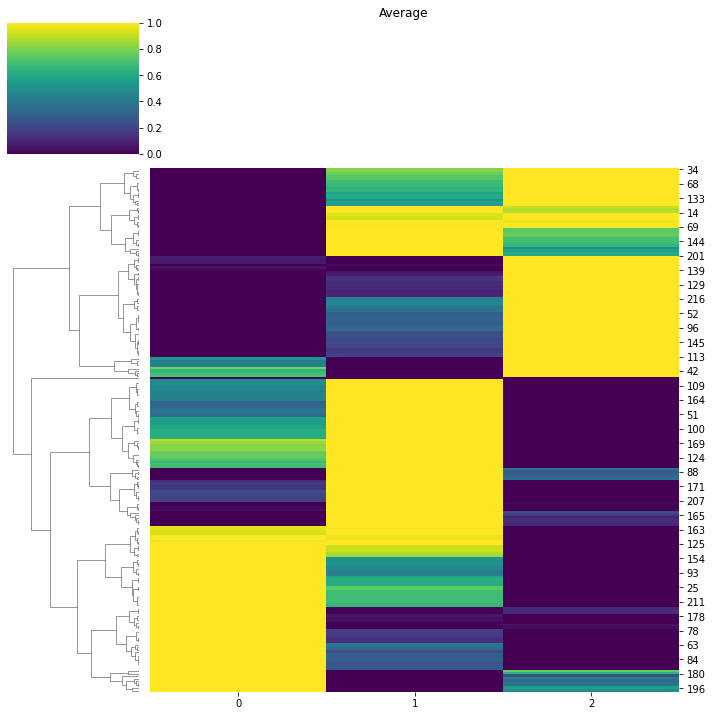

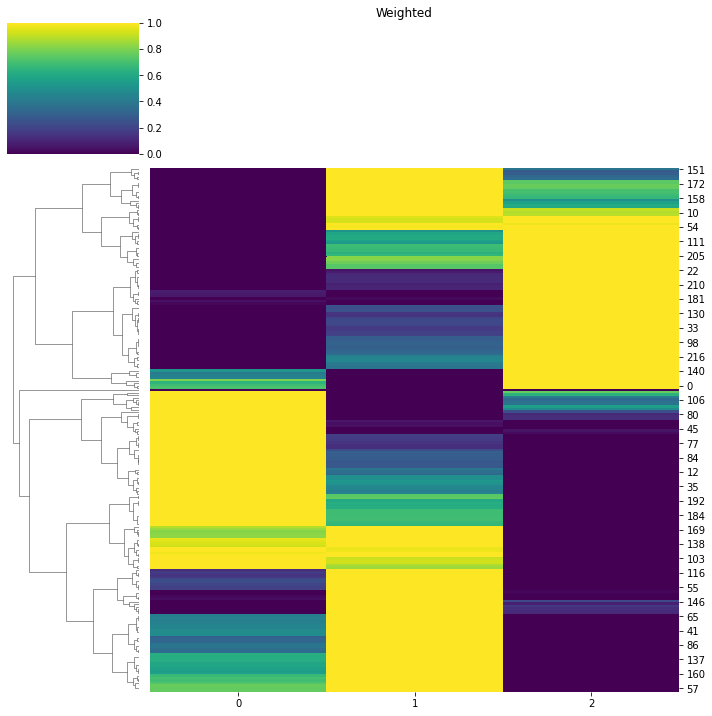

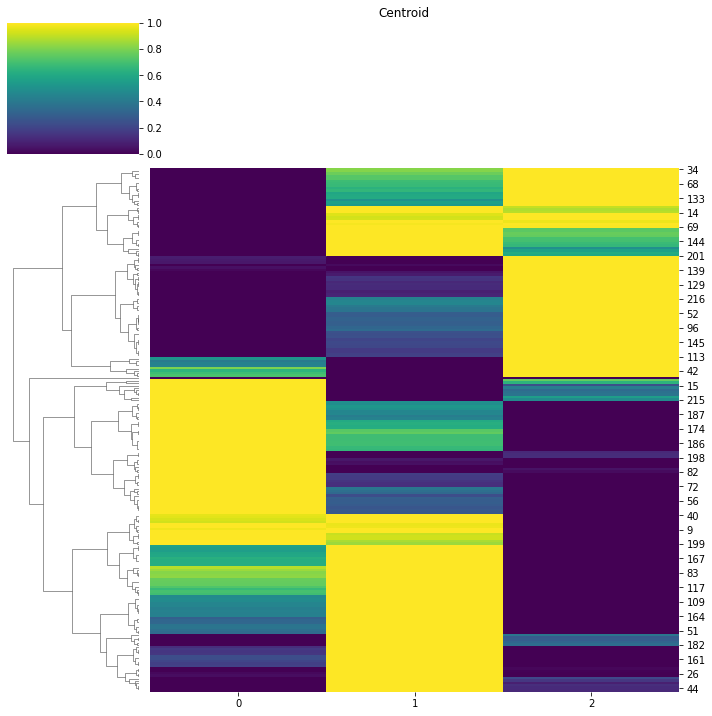

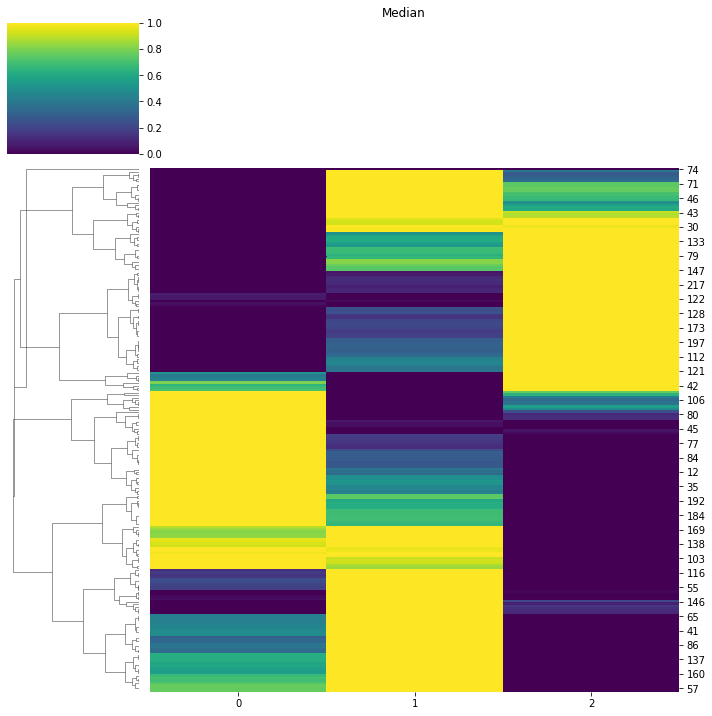

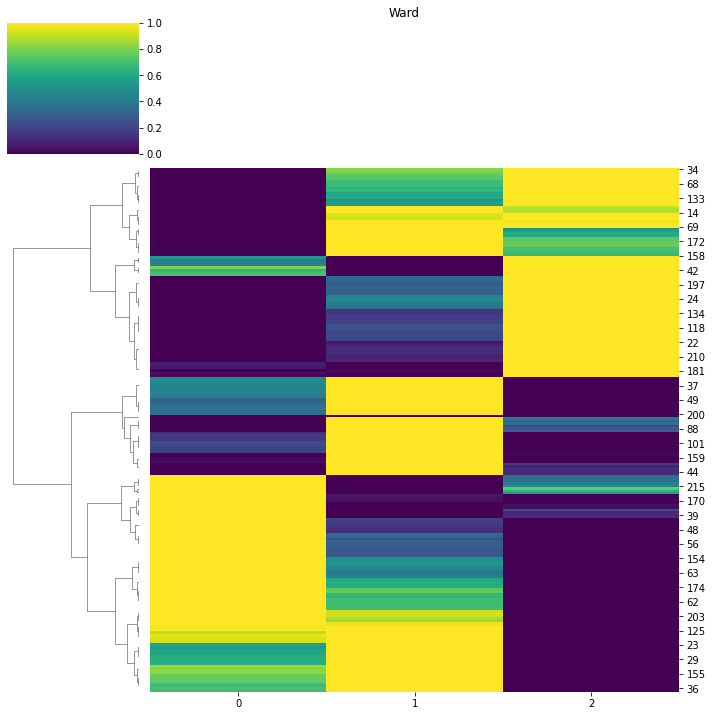

In [19]:
lips = pd.read_csv('lipids_gs.csv',index_col=0)
#print(lips.head())
X = lips[['Fold change rings', 'Fold change trophs','Fold change schizonts']].values
for i in range(len(X)):
    proxy = X[i]
    if proxy.sum()!=0:
        proxy = (proxy-proxy.min())/(proxy.max()-proxy.min())
    X[i] = proxy
    
orders = pd.DataFrame(columns=['single', 'complete','average','weighted','centroid','median','ward'])
dic_linkage = {}

for meth in ['single', 'complete','average','weighted','centroid','median','ward']:   
    result = sns.clustermap(X, method=meth,
                   col_cluster=False,
                   cmap="viridis"
                   )
    orders[meth] = result.dendrogram_row.reordered_ind
    #pd_fcluster[meth] = fcluster(result.dendrogram_row.linkage, 2., criterion='distance')
    dic_linkage[meth] = result.dendrogram_row.linkage
    plt.title(meth.capitalize(),position=(3.,0))
    plt.tight_layout()
    plt.show()

In [20]:
dic_linkage

{'single': array([[6.20000000e+01, 1.84000000e+02, 4.63499720e-05, 2.00000000e+00],
        [1.04000000e+02, 1.47000000e+02, 7.23420702e-05, 2.00000000e+00],
        [6.00000000e+01, 2.18000000e+02, 4.25578871e-04, 3.00000000e+00],
        [1.32000000e+02, 2.17000000e+02, 5.04078824e-04, 2.00000000e+00],
        [1.29000000e+02, 2.21000000e+02, 5.77152849e-04, 3.00000000e+00],
        [3.30000000e+01, 1.36000000e+02, 7.79244548e-04, 2.00000000e+00],
        [1.37000000e+02, 1.88000000e+02, 9.43166386e-04, 2.00000000e+00],
        [1.66000000e+02, 1.90000000e+02, 1.27730487e-03, 2.00000000e+00],
        [1.90000000e+01, 1.21000000e+02, 1.47898456e-03, 2.00000000e+00],
        [1.86000000e+02, 2.11000000e+02, 1.81099179e-03, 2.00000000e+00],
        [1.00000000e+00, 1.13000000e+02, 1.90589693e-03, 2.00000000e+00],
        [1.57000000e+02, 1.93000000e+02, 1.94941270e-03, 2.00000000e+00],
        [6.70000000e+01, 2.03000000e+02, 1.96698072e-03, 2.00000000e+00],
        [1.15000000e+02, 1.7

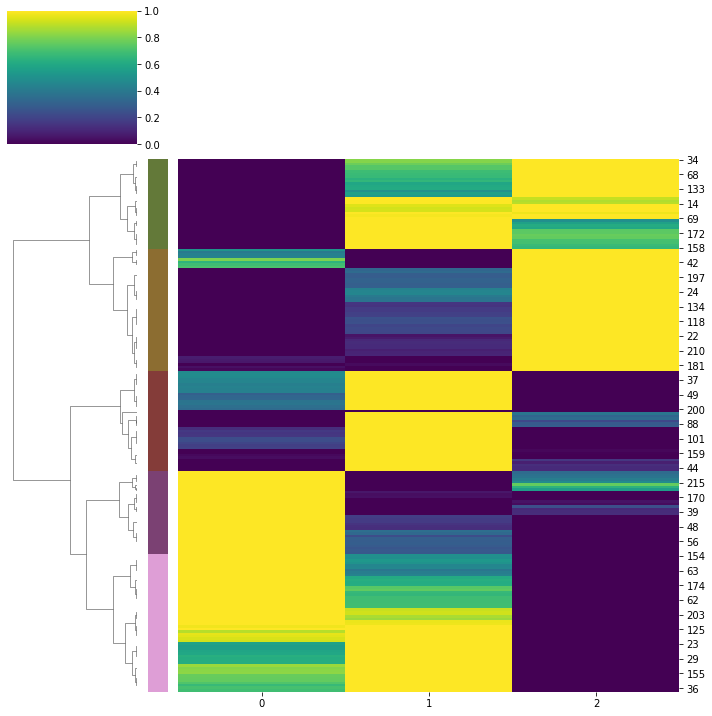

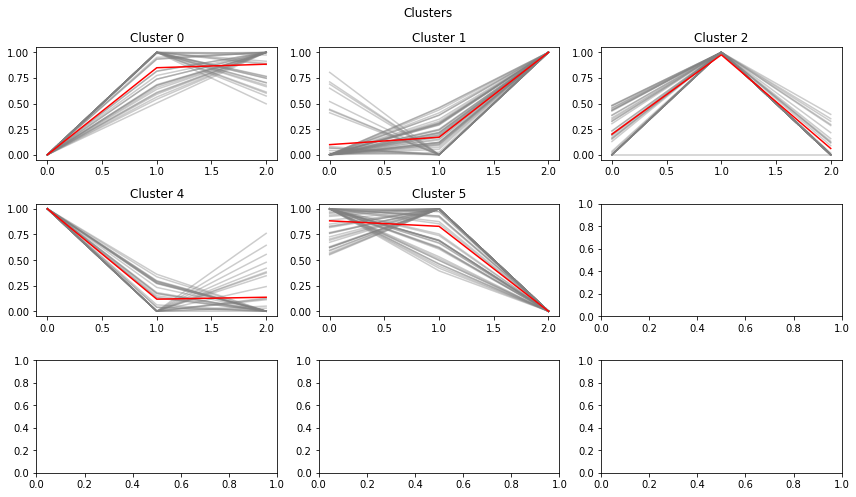

In [21]:
import math
import matplotlib.cm as cm
from matplotlib.colors import Normalize
# Make maximum Cluster number and than color them, but needs dendrogram_row.linkage
# select maximum number of clusters
#cluster_labels = fcluster(result.dendrogram_row.linkage, 2.5, criterion='distance')
linkage_dis = {'ward':2.5,        # 1 for 12 groups
               'single':0.099,    # not good measure
               'complete':1.2,    # 0.5 for 12 groups
               'average':0.7,     # 0.3 for 12 groups
               'weighted':0.7,    # 0.29 for 12 groups
               'centroid':0.65,   # 0.299 for 12 groups
               'median':0.7       # 0.28 for 12 groups
              }
meth = 'ward'
cluster_labels = fcluster(dic_linkage[meth], linkage_dis[meth], criterion='distance')

cmap = cm.tab20b
norm = Normalize(vmin=0, vmax=len(set(cluster_labels)))
values = [cmap(norm(x)) for x  in set(cluster_labels)]
lut = dict(zip(set(cluster_labels), values))
row_colors= [lut[x] for x in cluster_labels]

result = sns.clustermap(X, method=meth,
                        col_cluster=False,
                        cmap="viridis",
                        row_colors=row_colors
                   )
plt.tight_layout()
plt.show()


labels = cluster_labels
cluster_count = len(set(labels))
series_list= X

som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(series_list))))
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(12,7))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(series_list[i],c="gray",alpha=0.4)
                cluster.append(series_list[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.tight_layout()       
plt.show()

In [22]:
X = lips[['Fold change rings', 'Fold change trophs','Fold change schizonts']].values
X = np.nan_to_num(X)
for i in range(len(X)):
    proxy = X[i]
    if proxy.sum()!=0:
        proxy = (proxy-proxy.min())/(proxy.max()-proxy.min())
    X[i] = proxy

In [23]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

lips = pd.read_csv('lipids_gs.csv',index_col=0)

X = lips.values
for i in range(len(X)):
    X[i] = X[i].reshape(1,-1)
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
lips.iloc[52]

In [ ]:
from tslearn.metrics import dtw
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram

# Italy Power Demand time series are loaded in a pd.Series format.
# The dtw_distance function expects series to be shaped as a (l, m) array, 
# where l=length of series, m=# dimensions           
series_list = lips.values
for i in range(len(series_list)):
    series_list[i] = series_list[i].reshape(1,-1)
# Initialize distance matrix
n_series = len(series_list)
distance_matrix = np.zeros(shape=(n_series, n_series))

# Build distance matrix
for i in range(n_series):
    for j in range(n_series):
        x = series_list[i]  
        y = series_list[j]
        if i != j:
            dist = dtw(x, y)
            distance_matrix[i, j] = dist
            

def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    
    return Z

linkage_matrix = hierarchical_clustering(distance_matrix, method='complete')

In [ ]:
from scipy.cluster.hierarchy import fcluster

# select maximum number of clusters
cluster_labels = fcluster(linkage_matrix, 4, criterion='maxclust')
print(np.unique(cluster_labels))

cluster_labels = fcluster(linkage_matrix, 10, criterion='maxclust')
print(np.unique(cluster_labels))


# hand-select an appropriate cut-off on the dendrogram
cluster_labels = fcluster(linkage_matrix, 600, criterion='distance')
print(np.unique(cluster_labels))

cluster_labels = fcluster(linkage_matrix, 800, criterion='distance')
print(np.unique(cluster_labels))


In [ ]:
from sklearn.preprocessing import MinMaxScaler
lips = pd.read_csv('lipids_gs.csv',index_col=0)

series_list = lips.values.copy()

for i in range(len(series_list)):
    scaler = MinMaxScaler()
    fit = scaler.fit_transform(series_list[i].reshape(-1,1))
    series_list[i] = fit.reshape(1,-1)

In [ ]:
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
import math

cluster_count = 5
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count,
                      metric="softdtw",
                      metric_params={"gamma": .01},
                      verbose=True,
                      random_state=0)

labels = km.fit_predict(series_list)

In [ ]:
labels

In [ ]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(series_list))))
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(20,20))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(series_list[i],c="gray",alpha=0.4)
                cluster.append(series_list[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

In [ ]:
from sklearn.cluster import OPTICS
clust = OPTICS(xi=0.05, min_cluster_size=0.01)

# Run the fit
clust.fit(X)
clust.labels_
# OPTICS
plt.scatter(x=lips.index, y=clust.labels_)

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(25, 10))
plt.title("Customers Dendrogram")

# Selecting Annual Income and Spending Scores by index
selected_data = series_list
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

In [ ]:
fold_names =['Fold change rings', 'Fold change trophs',
             'Fold change schizonts']
df_gs_lip[fold_names].to_csv('lipids_gs.csv', sep=',')

In [ ]:

df2 = df_gs_lip.loc[:, ['Mean: urbcs','Mean: rings', 'Mean: trophs','Mean: schizonts']].stack().reset_index()
#df2

In [ ]:
df_gs['Fold change rings'].plot()